## Imports

In [ ]:
# Install Google Cloud Storage (Hosting NSynth Dataset)
!pip install gcsfs
!pip install tqdm

In [ ]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import io
import numpy as np

In [ ]:
# Authenticate with Google Cloud
from google.colab import auth
auth.authenticate_user()

# Set the paths to JSON files in the GCS bucket
bucket_name = 'nsynth-dataset'
train_json_path = f'gs://{bucket_name}/datasets/nsynth-train/examples.json'
test_json_path = f'gs://{bucket_name}/datasets/nsynth-test/examples.json'
valid_json_path = f'gs://{bucket_name}/datasets/nsynth-valid/examples.json'

# Function to load JSON data from GCS and convert it to DataFrame
def load_json_to_df(json_path):
    with pd.io.common.get_handle(json_path, 'r', storage_options={'token': 'cloud'}) as f:
        data = json.load(f.handle)
    return pd.DataFrame.from_dict(data, orient='index')

# Load full datasets
train_df = load_json_to_df(train_json_path)
test_df = load_json_to_df(test_json_path)
valid_df = load_json_to_df(valid_json_path)

In [ ]:
# Add unique key column for merging json with audio for model
for df in [train_df, test_df, valid_df]:
    df['key'] = df.index
df.head()

note_str  sample_rate  \
keyboard_acoustic_004-060-025      keyboard_acoustic_004-060-025        16000   
bass_synthetic_033-050-100            bass_synthetic_033-050-100        16000   
bass_synthetic_009-052-050            bass_synthetic_009-052-050        16000   
keyboard_electronic_003-064-127  keyboard_electronic_003-064-127        16000   
bass_synthetic_034-030-050            bass_synthetic_034-030-050        16000   

                                                      qualities_str  \
keyboard_acoustic_004-060-025                        [dark, reverb]   
bass_synthetic_033-050-100                                   [dark]   
bass_synthetic_009-052-050       [bright, distortion, long_release]   
keyboard_electronic_003-064-127                                  []   
bass_synthetic_034-030-050               [distortion, tempo-synced]   

                                 instrument_source instrument_family_str  \
keyboard_acoustic_004-060-025                    0              keyboard   
bass_synthetic_033-050-100                       2                  bass   
bass_synthetic_009-052-050                       2                  bass   
keyboard_electronic_003-064-127                  1              keyboard   
bass_synthetic_034-030-050                       2                  bass   

                                 instrument_family    note  \
keyboard_acoustic_004-060-025                    4  278915   
bass_synthetic_033-050-100                       0  270361   
bass_synthetic_009-052-050                       0  270001   
keyboard_electronic_003-064-127                  4   50978   
bass_synthetic_034-030-050                       0  265159   

                                instrument_source_str  \
keyboard_acoustic_004-060-025                acoustic   
bass_synthetic_033-050-100                  synthetic   
bass_synthetic_009-052-050                  synthetic   
keyboard_electronic_003-064-127            electronic   
bass_synthetic_034-030-050                  synthetic   

                                                      qualities  pitch  \
keyboard_acoustic_004-060-025    [0, 1, 0, 0, 0, 0, 0, 0, 1, 0]     60   
bass_synthetic_033-050-100       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]     50   
bass_synthetic_009-052-050       [1, 0, 1, 0, 1, 0, 0, 0, 0, 0]     52   
keyboard_electronic_003-064-127  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]     64   
bass_synthetic_034-030-050       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1]     30   

                                          instrument_str  instrument  \
keyboard_acoustic_004-060-025      keyboard_acoustic_004         327   
bass_synthetic_033-050-100            bass_synthetic_033         417   
bass_synthetic_009-052-050            bass_synthetic_009         150   
keyboard_electronic_003-064-127  keyboard_electronic_003          65   
bass_synthetic_034-030-050            bass_synthetic_034         420   

                                 velocity                              key  
keyboard_acoustic_004-060-025          25    keyboard_acoustic_004-060-025  
bass_synthetic_033-050-100            100       bass_synthetic_033-050-100  
bass_synthetic_009-052-050             50       bass_synthetic_009-052-050  
keyboard_electronic_003-064-127       127  keyboard_electronic_003-064-127  
bass_synthetic_034-030-050             50       bass_synthetic_034-030-050

In [ ]:
# ////////////////////
sample_fraction = 0.1  # Changes Fractional Data Input Down Entire Pipeline
# ////////////////////

In [ ]:
import os
import random
import pandas as pd
import librosa
import gcsfs

# Set up paths to GCS audio folders with .WAV files
bucket_name = 'nsynth-dataset'
train_audio_path = f'gs://{bucket_name}/datasets/nsynth-train/audio/'
test_audio_path = f'gs://{bucket_name}/datasets/nsynth-test/audio/'
valid_audio_path = f'gs://{bucket_name}/datasets/nsynth-valid/audio/'

# Initialize GCS File System
fs = gcsfs.GCSFileSystem()

# Function to load a subset of audio file paths from GCS with random sampling
def load_audio_files_sample(audio_path,
                            sample_rate=16000,
                            sample_fraction = sample_fraction,
                            random_seed=42):
    audio_data = []

    # List of all audio files with random sampling using a fixed seed
    all_files = list(fs.glob(audio_path + '*.wav'))
    sample_count = int(len(all_files) * sample_fraction)
    random.seed(random_seed)  # Ensure reproducibility
    sample_files = random.sample(all_files, sample_count)

    for audio_file in sample_files:
        try:
            # Load audio using librosa directly from GCS
            with fs.open(audio_file, 'rb') as f:
                y, sr = librosa.load(f, sr=sample_rate)
                audio_data.append({
                    'file_path': audio_file,
                    'sample_rate': sr,
                    'audio': y,
                    'duration': len(y) / sr
                })
        except Exception as e:
            print(f"Error loading {audio_file}: {e}")
    return pd.DataFrame(audio_data)

In [ ]:
# Load and sample audio data
train_audio_df = load_audio_files_sample(train_audio_path, sample_fraction=sample_fraction)
test_audio_df = load_audio_files_sample(test_audio_path, sample_fraction=sample_fraction)
valid_audio_df = load_audio_files_sample(valid_audio_path, sample_fraction=sample_fraction)

# Add keys to audio DataFrames by extracting from file path names
for audio_df in [train_audio_df, test_audio_df, valid_audio_df]:
    audio_df['key'] = audio_df['file_path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

# Filter JSON data to keep only matching keys
train_df_sample = train_df[train_df['key'].isin(train_audio_df['key'])]
valid_df_sample = valid_df[valid_df['key'].isin(valid_audio_df['key'])]
test_df_sample = test_df[test_df['key'].isin(test_audio_df['key'])]

# Merge JSON and Audio DataFrames
combined_train_df = pd.merge(train_audio_df, train_df_sample, on='key', how='inner')
combined_valid_df = pd.merge(valid_audio_df, valid_df_sample, on='key', how='inner')
combined_test_df = pd.merge(test_audio_df, test_df_sample, on='key', how='inner')

# Extract timbral qualities from the JSON data
combined_train_df['timbral_qualities'] = combined_train_df['qualities']
combined_valid_df['timbral_qualities'] = combined_valid_df['qualities']
combined_test_df['timbral_qualities'] = combined_test_df['qualities']

# Convert timbral qualities to numpy arrays for model input
y_timbral_train = np.array(combined_train_df['timbral_qualities'].tolist())
y_timbral_val = np.array(combined_valid_df['timbral_qualities'].tolist())
y_timbral_test = np.array(combined_test_df['timbral_qualities'].tolist())

# Display to verify
print("Combined Train Data (sample):")
print(combined_train_df.head())

# Check shapes of the qualities
print("Shape of y_timbral_train:", y_timbral_train.shape)
print("Shape of y_timbral_val:", y_timbral_val.shape)
print("Shape of y_timbral_test:", y_timbral_test.shape)

Combined Train Data (sample):
                                           file_path  sample_rate_x  \
0  nsynth-dataset/datasets/nsynth-train/audio/bas...          16000   
1  nsynth-dataset/datasets/nsynth-train/audio/bas...          16000   
2  nsynth-dataset/datasets/nsynth-train/audio/key...          16000   
3  nsynth-dataset/datasets/nsynth-train/audio/key...          16000   
4  nsynth-dataset/datasets/nsynth-train/audio/gui...          16000   

                                               audio  duration  \
0  [-0.0018005371, -0.014831543, -0.0031433105, 0...       4.0   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       4.0   
2  [0.00030517578, -0.00039672852, 0.0005187988, ...       4.0   
3  [0.0, 0.0, 0.0, 0.0, -3.0517578e-05, 3.0517578...       4.0   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       4.0   

                               key    note  sample_rate_y  pitch  \
0       bass_synthetic_125-073-127  221307          16000     73   
1       ba

In [ ]:
# Timbral quality column names as per NSynth
qualities_columns = ["bright", "dark", "distortion", "fast_decay", "long_release",
                     "multiphonic", "nonlinear_env", "percussive", "reverb", "tempo_synced"]

# Map `qualities` binary vector to a DataFrame with named columns
combined_train_df[qualities_columns] = pd.DataFrame(
    combined_train_df['timbral_qualities'].tolist(), index=combined_train_df.index
)
combined_valid_df[qualities_columns] = pd.DataFrame(
    combined_valid_df['timbral_qualities'].tolist(), index=combined_valid_df.index
)
combined_test_df[qualities_columns] = pd.DataFrame(
    combined_test_df['timbral_qualities'].tolist(), index=combined_test_df.index
)

# Display to verify
print("Combined Train Data with Timbral Qualities (sample):")
print(combined_train_df[qualities_columns].head())

Combined Train Data with Timbral Qualities (sample):
   bright  dark  distortion  fast_decay  long_release  multiphonic  \
0       0     0           0           0             1            0   
1       0     0           0           1             0            0   
2       1     0           0           0             1            0   
3       0     1           0           0             0            0   
4       0     0           0           0             0            0   

   nonlinear_env  percussive  reverb  tempo_synced  
0              0           0       0             0  
1              0           1       0             0  
2              0           0       0             0  
3              0           0       0             0  
4              0           0       0             0  


In [ ]:
from tensorflow.keras.utils import to_categorical

# Extract Instrument Source as Labels
instrument_source_classes = combined_train_df['instrument_source_str'].unique()
num_sources = len(instrument_source_classes)

# Create a mapping from source name to index
source_to_index = {name: idx for idx, name in enumerate(instrument_source_classes)}

# Apply mapping to create numerical labels for instrument sources
combined_train_df['instrument_source_label'] = combined_train_df['instrument_source_str'].map(source_to_index)
combined_valid_df['instrument_source_label'] = combined_valid_df['instrument_source_str'].map(source_to_index)
combined_test_df['instrument_source_label'] = combined_test_df['instrument_source_str'].map(source_to_index)

# Convert to one-hot encoding
y_source_train = to_categorical(combined_train_df['instrument_source_label'], num_classes=num_sources)
y_source_val = to_categorical(combined_valid_df['instrument_source_label'], num_classes=num_sources)
y_source_test = to_categorical(combined_test_df['instrument_source_label'], num_classes=num_sources)

# Display to verify
print("Instrument Source Mapping:", source_to_index)
print("Sample Instrument Source Labels (Train):", combined_train_df[['instrument_source_str', 'instrument_source_label']].head())

Instrument Source Mapping: {'synthetic': 0, 'electronic': 1, 'acoustic': 2}
Sample Instrument Source Labels (Train):   instrument_source_str  instrument_source_label
0             synthetic                        0
1             synthetic                        0
2            electronic                        1
3            electronic                        1
4             synthetic                        0


## Exploratory Data Analysis

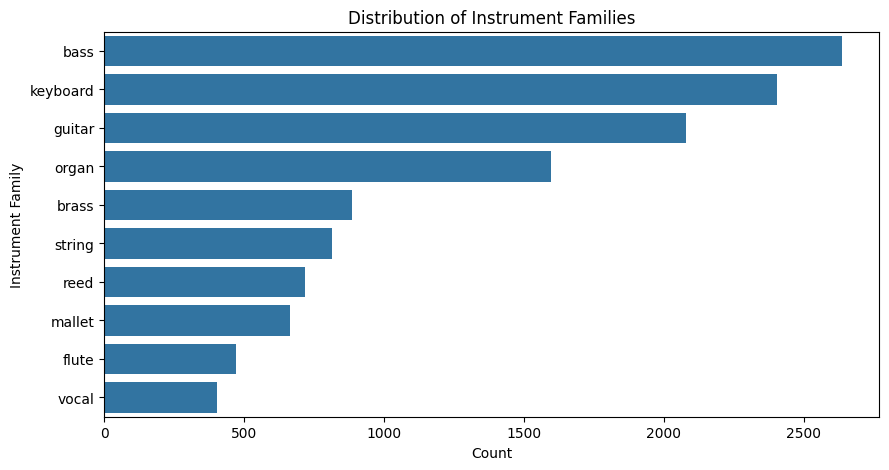

In [ ]:
# Distribution of Instrument Families
plt.figure(figsize=(10, 5))
sns.countplot(y='instrument_family_str', data=df,
              order=df['instrument_family_str'].value_counts().index)
plt.title("Distribution of Instrument Families", fontsize=12)
plt.xlabel("Count")
plt.ylabel("Instrument Family")
plt.show()

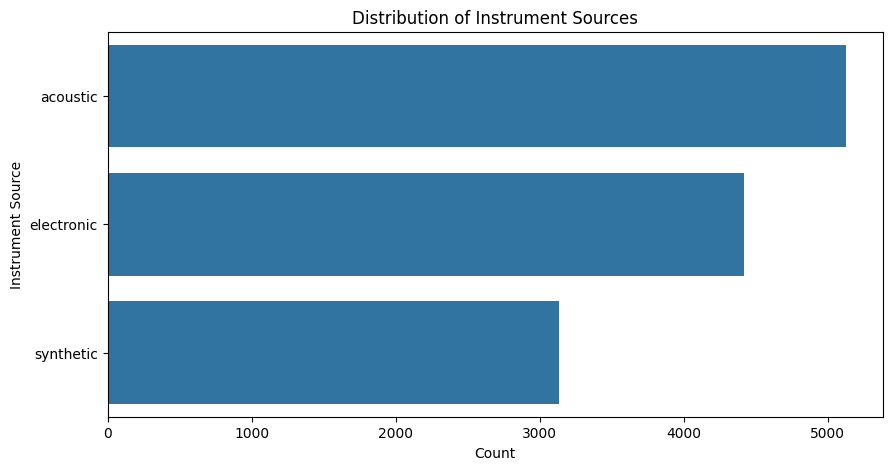

In [ ]:
# Distribution of Instrument Sources
plt.figure(figsize=(10, 5))
sns.countplot(y='instrument_source_str', data=df,
              order=df['instrument_source_str'].value_counts().index)
plt.title("Distribution of Instrument Sources", fontsize=12)
plt.xlabel("Count", fontsize=10)
plt.ylabel("Instrument Source", fontsize=10)
plt.show()

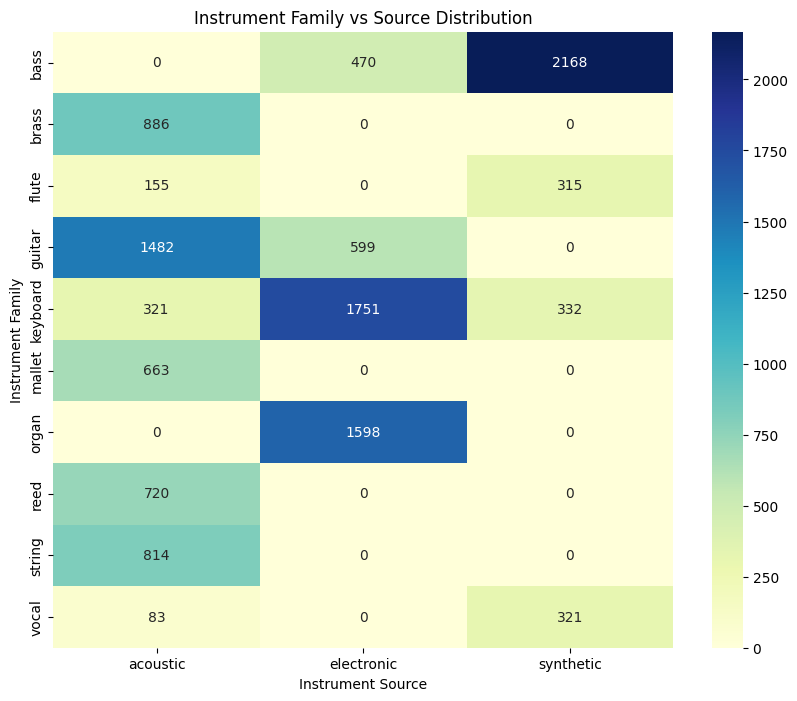

In [ ]:
# Instrument Family and Source Distribution Heatmap
# Plots the distribution of instrument families vs instrument sources in a heatmap
family_source_count = df.pivot_table(index='instrument_family_str',
                                     columns='instrument_source_str',
                                     aggfunc='size',
                                     fill_value=0)
plt.figure(figsize=(10, 8))
sns.heatmap(family_source_count, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Instrument Family vs Source Distribution")
plt.xlabel("Instrument Source")
plt.ylabel("Instrument Family")
plt.show()

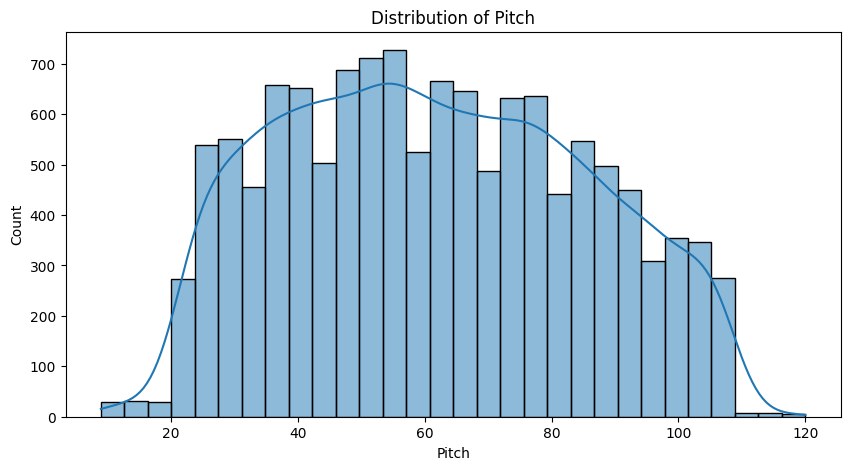

In [ ]:
# Distribution of Pitch
plt.figure(figsize=(10, 5))
sns.histplot(df['pitch'], bins=30, kde=True)
plt.title("Distribution of Pitch", fontsize=12)
plt.xlabel("Pitch")
plt.ylabel("Count")
plt.show()

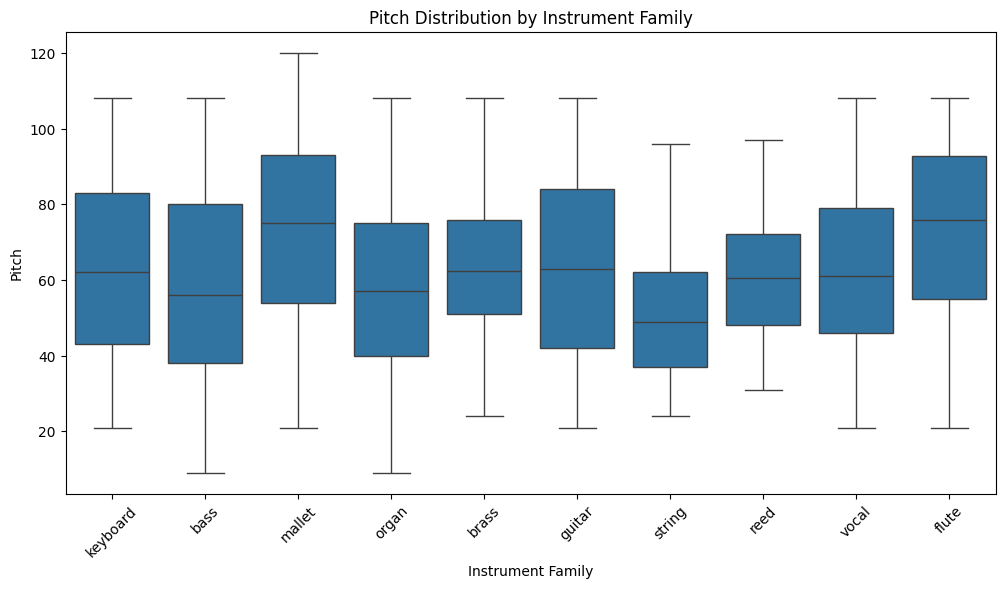

In [ ]:
# Pitch vs. Instrument Family
plt.figure(figsize=(12, 6))
sns.boxplot(x='instrument_family_str', y='pitch', data=df)
plt.title("Pitch Distribution by Instrument Family", fontsize=12)
plt.xlabel("Instrument Family", fontsize=10)
plt.ylabel("Pitch", fontsize=10)
plt.xticks(rotation=45)
plt.show()

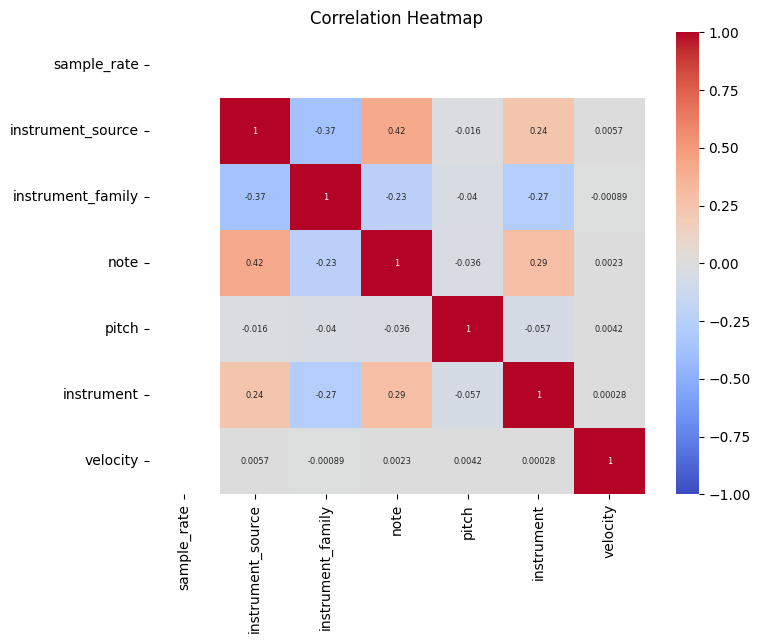

In [ ]:
# Correlation Heatmap
numeric_df = df.select_dtypes(include=[float, int])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm",
            vmin=-1, vmax=1, annot_kws={"size": 6})
plt.title("Correlation Heatmap", fontsize=12)
plt.show()

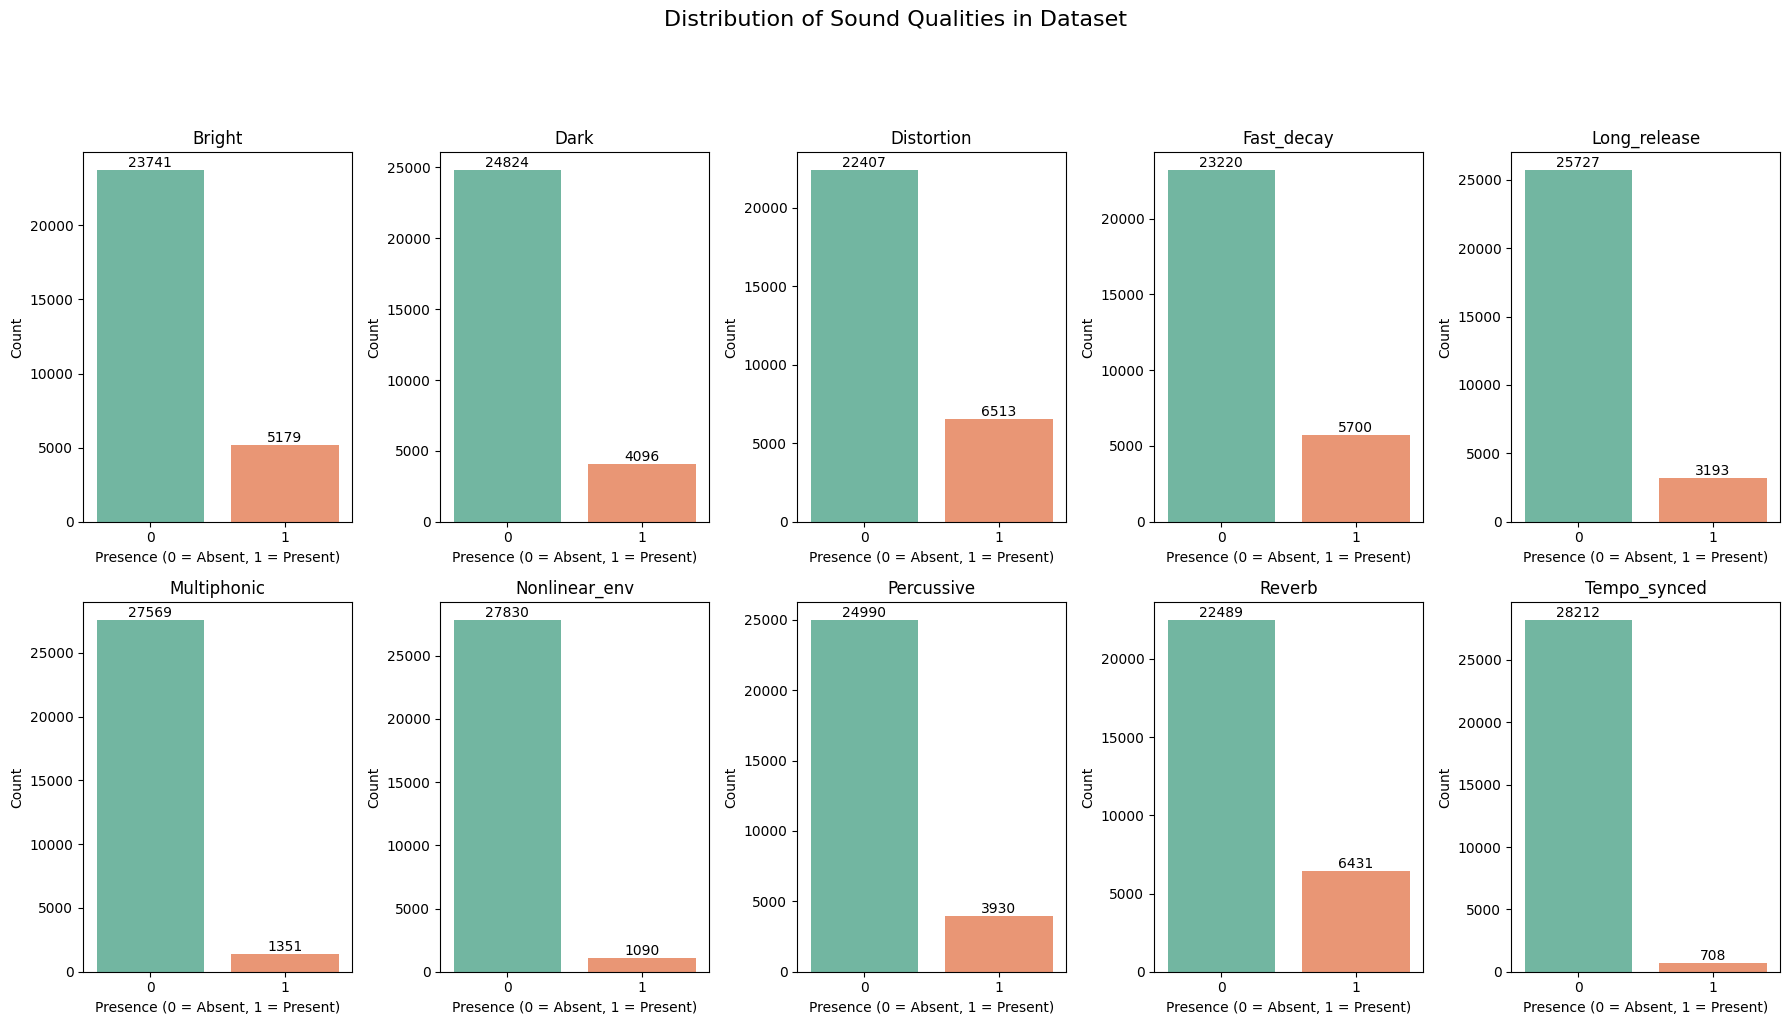

In [ ]:
# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(18, 10))
axes = axes.flatten()  # Flatten axes for easy iteration

# Plot each quality
qualities_columns = ["bright", "dark", "distortion", "fast_decay", "long_release",
                     "multiphonic", "nonlinear_env", "percussive", "reverb", "tempo_synced"]

for i, quality_name in enumerate(qualities_columns):
    sns.countplot(
        x=combined_train_df[quality_name],  # Assign x to hue
        hue=combined_train_df[quality_name],
        ax=axes[i],
        palette="Set2",
        legend=False  # Disable legend to prevent clutter
    )
    axes[i].set_title(quality_name.capitalize())
    axes[i].set_xlabel("Presence (0 = Absent, 1 = Present)")
    axes[i].set_ylabel("Count")
    # Annotate counts
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height())}',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='bottom')

# Title
plt.suptitle("Distribution of Sound Qualities in Dataset", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Make space for title
plt.show()

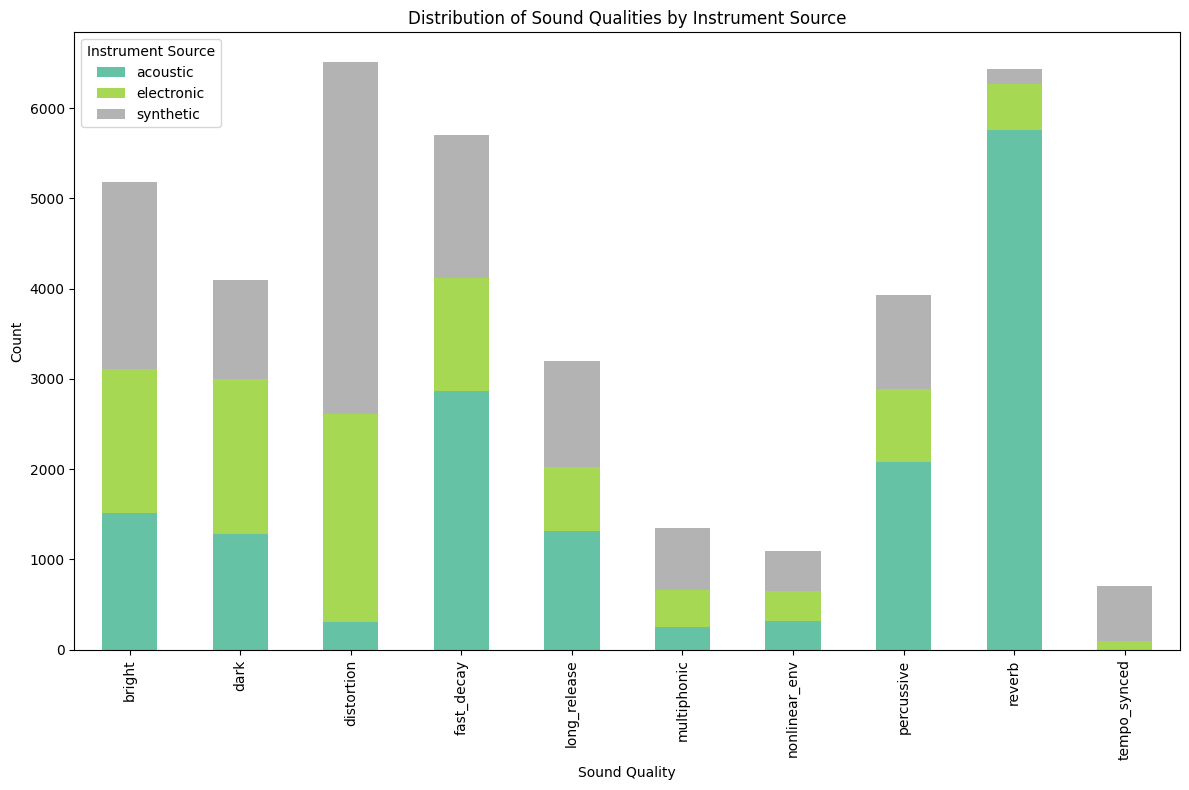

In [ ]:
# Group by instrument source and calculate the sum of each quality
qualities_by_source = combined_train_df.groupby("instrument_source_str")[qualities_columns].sum()

# Plot stacked bar chart
qualities_by_source.T.plot(kind="bar", stacked=True, figsize=(12, 8), colormap="Set2")
plt.title("Distribution of Sound Qualities by Instrument Source")
plt.xlabel("Sound Quality")
plt.ylabel("Count")
plt.legend(title="Instrument Source")
plt.tight_layout()
plt.show()

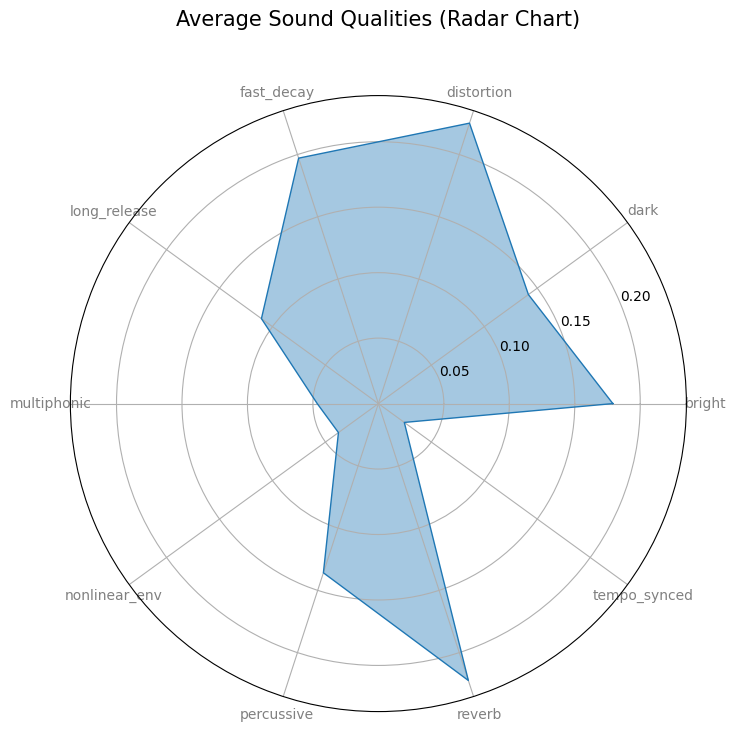

In [ ]:
from math import pi

# Calculate average qualities
avg_qualities = combined_train_df[qualities_columns].mean()

# Prepare data for radar chart
categories = list(avg_qualities.index)
values = avg_qualities.values.flatten().tolist()
values += values[:1]  # Close the circle for radar chart

# Create radar chart
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color="grey", size=10)

ax.plot(angles, values, linewidth=1, linestyle="solid")
ax.fill(angles, values, alpha=0.4)

plt.title("Average Sound Qualities (Radar Chart)", size=15, y=1.1)
plt.show()

## Visualizing Audio Files

In [ ]:
import os
import random
import pandas as pd
import librosa
import gcsfs

# Set up paths to GCS audio folders with .WAV files
bucket_name = 'nsynth-dataset'
train_audio_path = f'gs://{bucket_name}/datasets/nsynth-train/audio/'
test_audio_path = f'gs://{bucket_name}/datasets/nsynth-test/audio/'
valid_audio_path = f'gs://{bucket_name}/datasets/nsynth-valid/audio/'

# Initialize GCS File System
fs = gcsfs.GCSFileSystem()

# Function to load a subset of audio file paths from GCS with random sampling
def load_audio_files_sample(audio_path,
                            sample_rate=16000,
                            sample_fraction = sample_fraction,
                            random_seed=42):
    audio_data = []

    # List of all audio files with random sampling using a fixed seed
    all_files = list(fs.glob(audio_path + '*.wav'))
    sample_count = int(len(all_files) * sample_fraction)
    random.seed(random_seed)
    sample_files = random.sample(all_files, sample_count)

    for audio_file in sample_files:
        try:
            # Load audio using librosa directly from GCS
            with fs.open(audio_file, 'rb') as f:
                y, sr = librosa.load(f, sr=sample_rate)
                audio_data.append({
                    'file_path': audio_file,
                    'sample_rate': sr,
                    'audio': y,
                    'duration': len(y) / sr
                })
        except Exception as e:
            print(f"Error loading {audio_file}: {e}")
    return pd.DataFrame(audio_data)

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from IPython.display import Audio, display
import os

# Function to plot a spectrogram for a given audio signal
def plot_spectrogram(audio, sample_rate, title="Spectrogram"):
    # Generate the mel spectrogram with specified hop length
    S = librosa.feature.melspectrogram(y=audio,
                                       sr=sample_rate,
                                       n_mels=128,
                                       fmax=4096,
                                       hop_length=512)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB,
                             sr=sample_rate,
                             hop_length=512,
                             x_axis='time',
                             y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()

# Function to visualize spectrograms and play audio for a few samples in each dataset
def visualize_spectrograms_with_audio(df, title_prefix="", num_samples=5):
    for i in range(min(num_samples, len(df))):  # Display up to `num_samples` spectrograms
        audio_sample = df.iloc[i]['audio']
        sample_rate = df.iloc[i]['sample_rate']
        file_name = os.path.basename(df.iloc[i]['file_path'])

        # Display spectrogram
        plot_spectrogram(audio_sample, sample_rate, title=f"{title_prefix} - {file_name}")

        # Display audio player
        print(f"Playing audio: {title_prefix} - {file_name}")
        display(Audio(audio_sample, rate=sample_rate))

Train Audio Data Spectrograms:


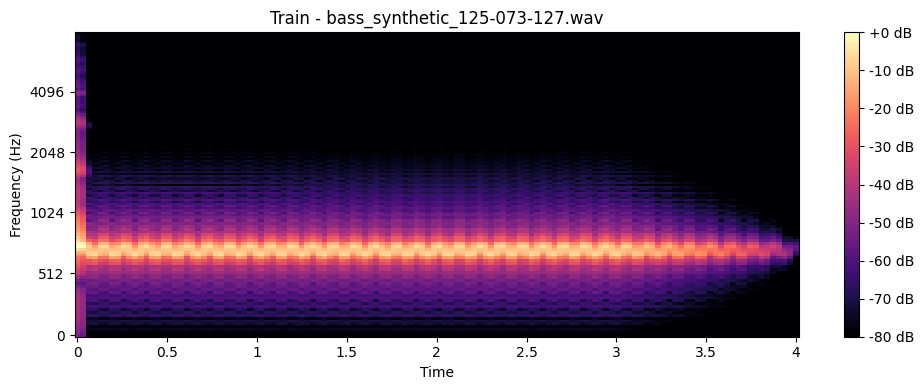

Playing audio: Train - bass_synthetic_125-073-127.wav


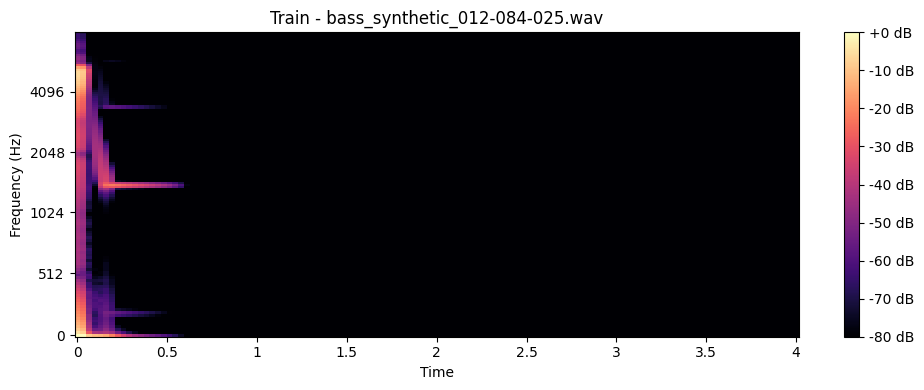

Playing audio: Train - bass_synthetic_012-084-025.wav


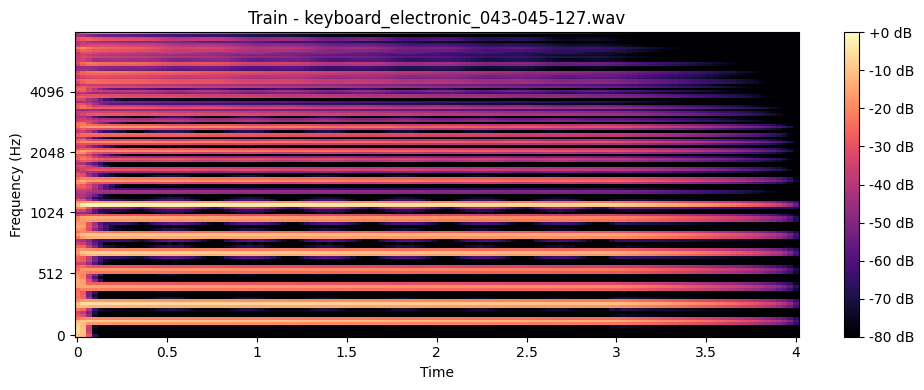

Playing audio: Train - keyboard_electronic_043-045-127.wav



Test Audio Data Spectrograms:


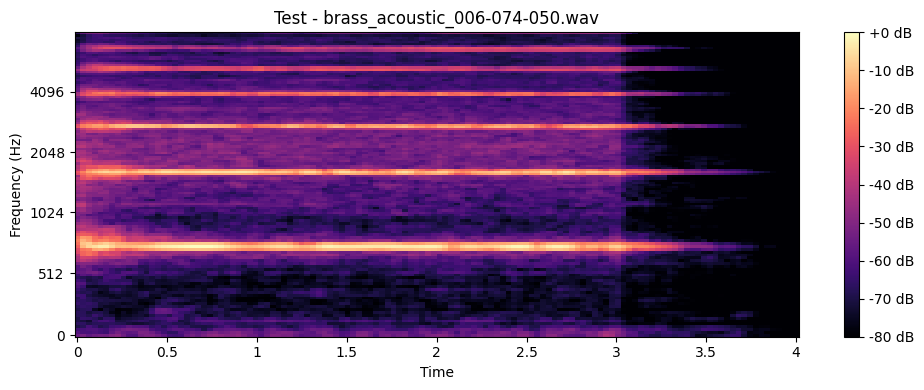

Playing audio: Test - brass_acoustic_006-074-050.wav


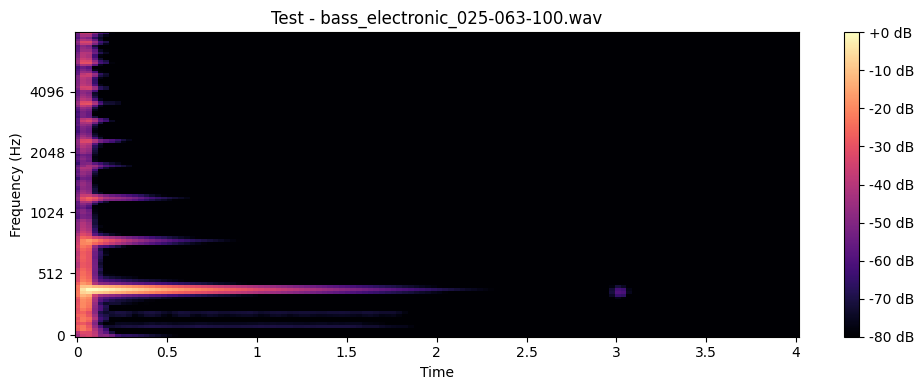

Playing audio: Test - bass_electronic_025-063-100.wav


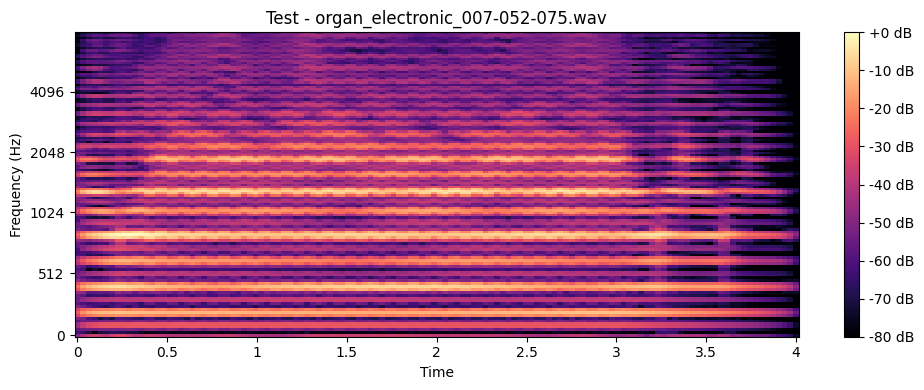

Playing audio: Test - organ_electronic_007-052-075.wav



Valid Audio Data Spectrograms:


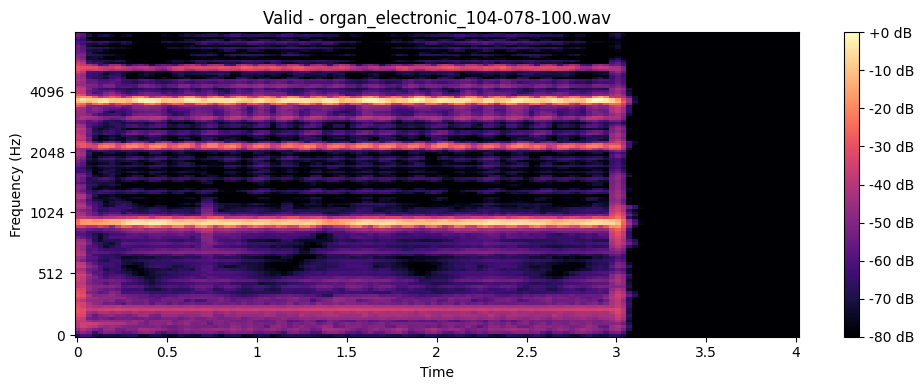

Playing audio: Valid - organ_electronic_104-078-100.wav


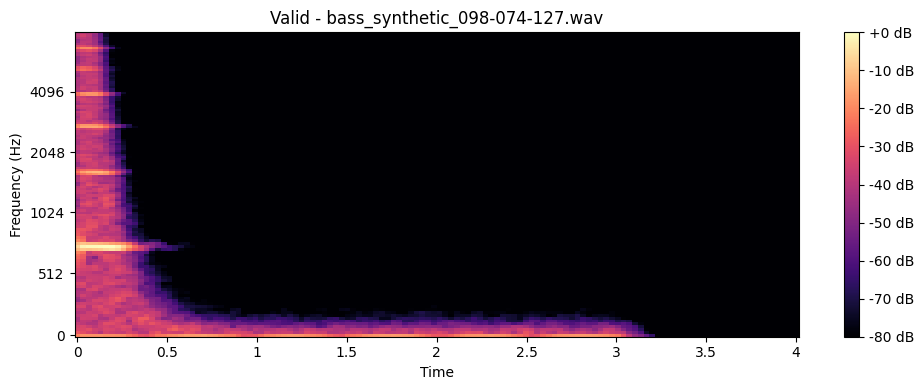

Playing audio: Valid - bass_synthetic_098-074-127.wav


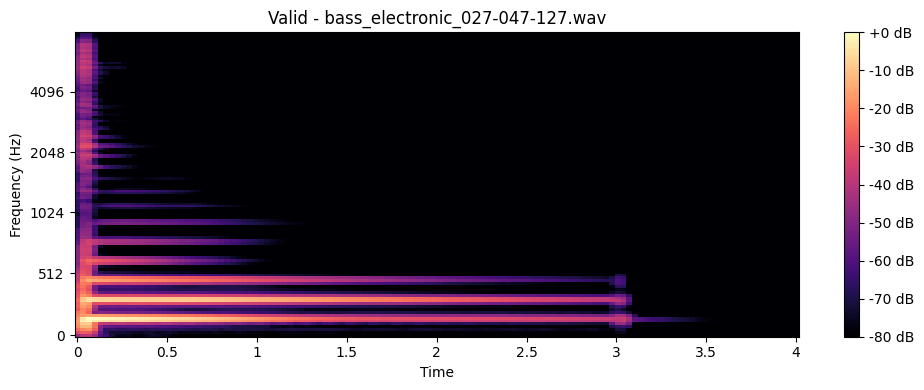

Playing audio: Valid - bass_electronic_027-047-127.wav


In [ ]:
# Visualize and play audio for each dataset
print("Train Audio Data Spectrograms:")
visualize_spectrograms_with_audio(train_audio_df, title_prefix="Train",
                                  num_samples=3)

print("\nTest Audio Data Spectrograms:")
visualize_spectrograms_with_audio(test_audio_df, title_prefix="Test",
                                  num_samples=3)

print("\nValid Audio Data Spectrograms:")
visualize_spectrograms_with_audio(valid_audio_df, title_prefix="Valid",
                                  num_samples=3)


Displaying features for bass_synthetic_125-073-127.wav:



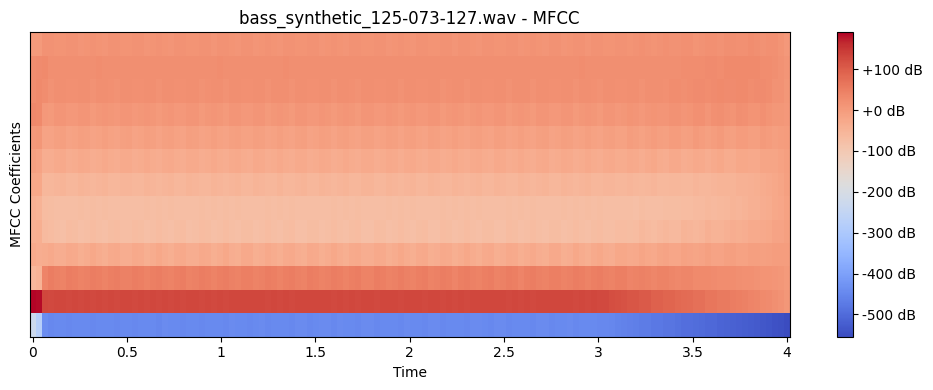

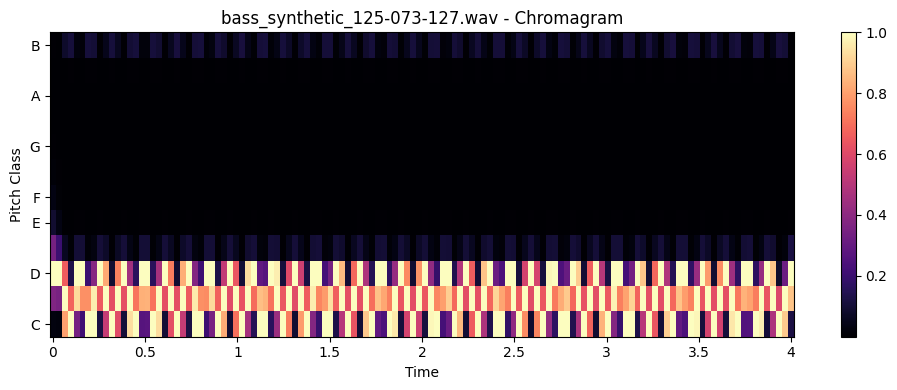

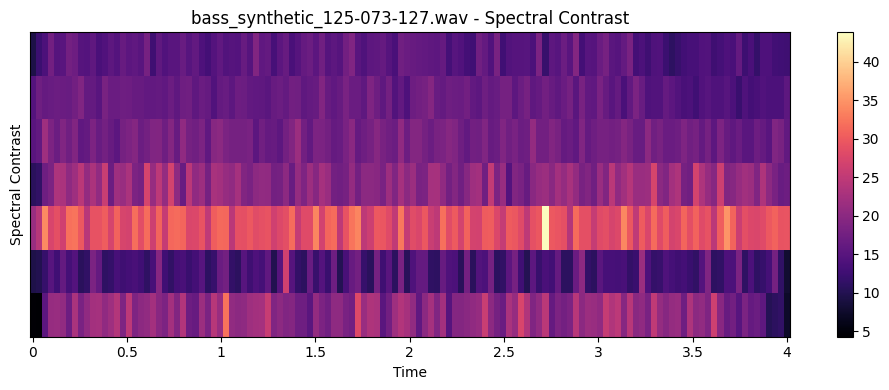


Displaying features for bass_synthetic_012-084-025.wav:



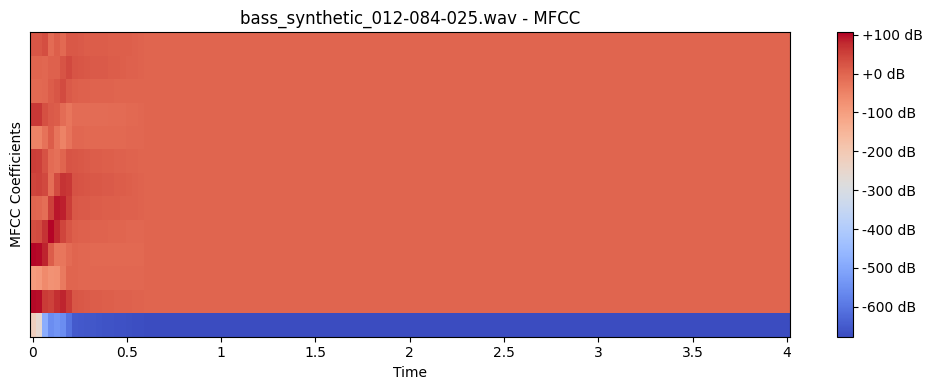

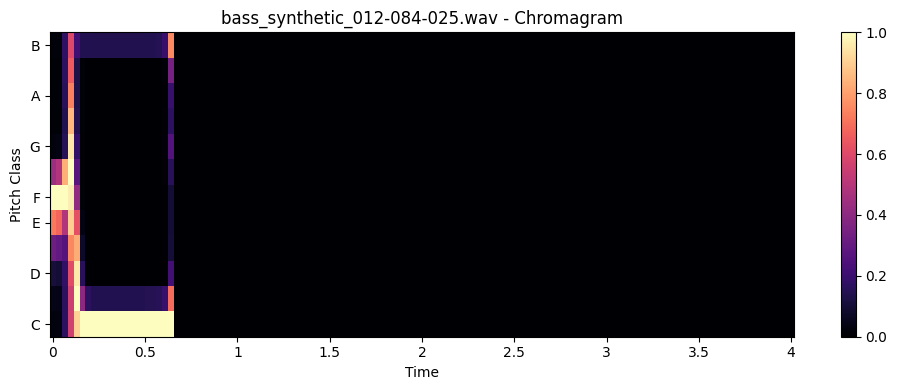

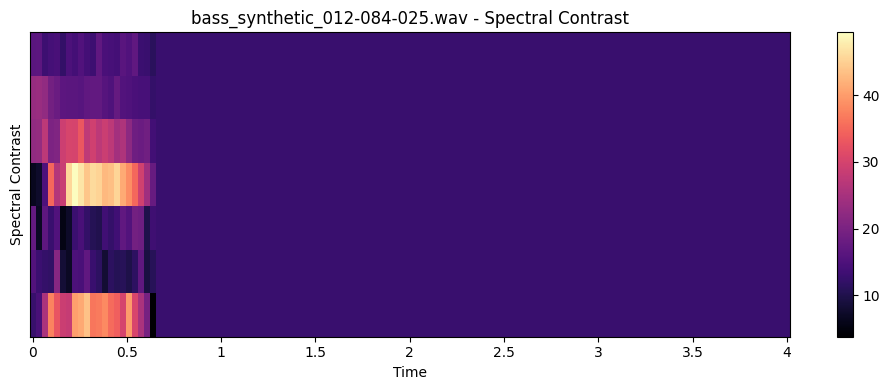


Displaying features for keyboard_electronic_043-045-127.wav:



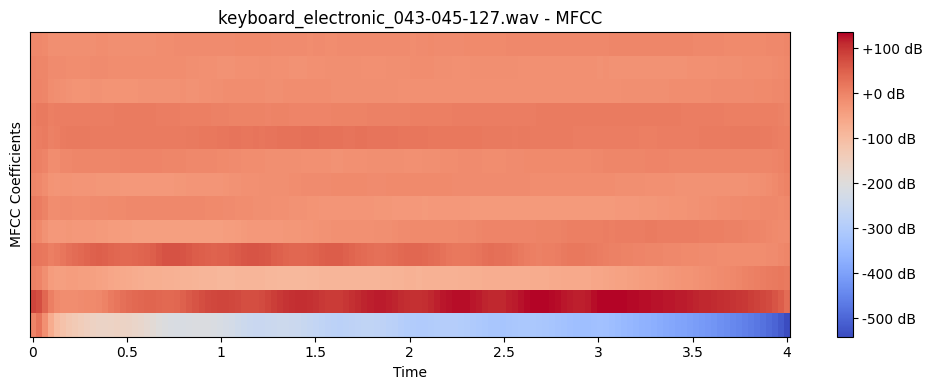

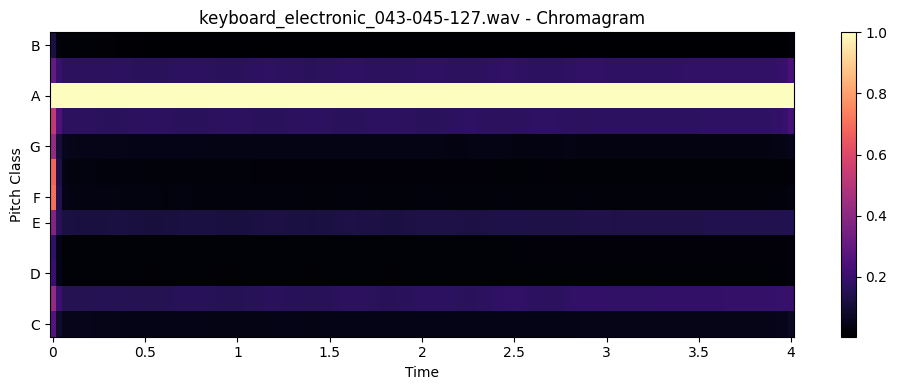

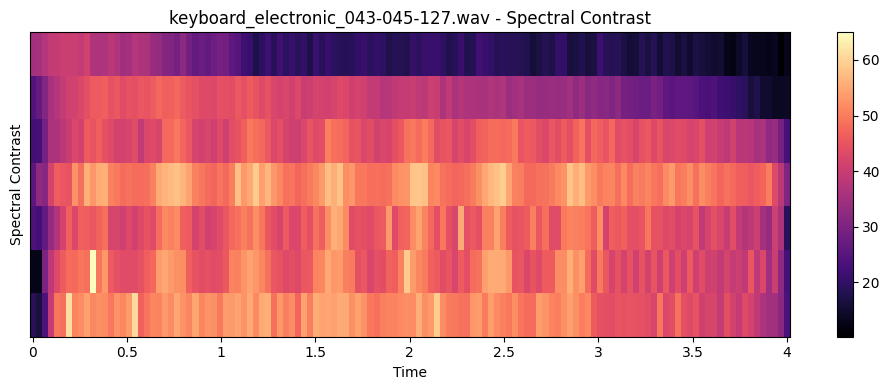


Displaying features for keyboard_electronic_004-075-100.wav:



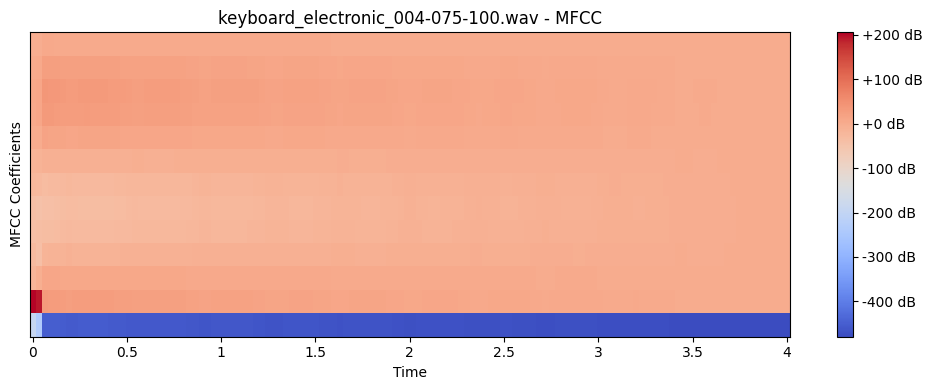

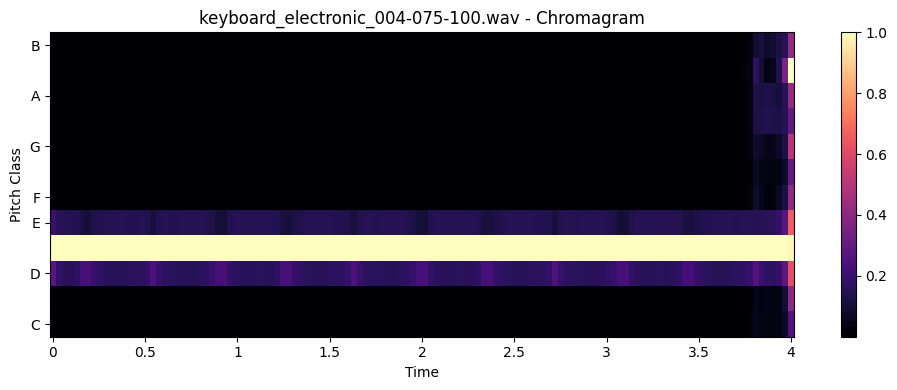

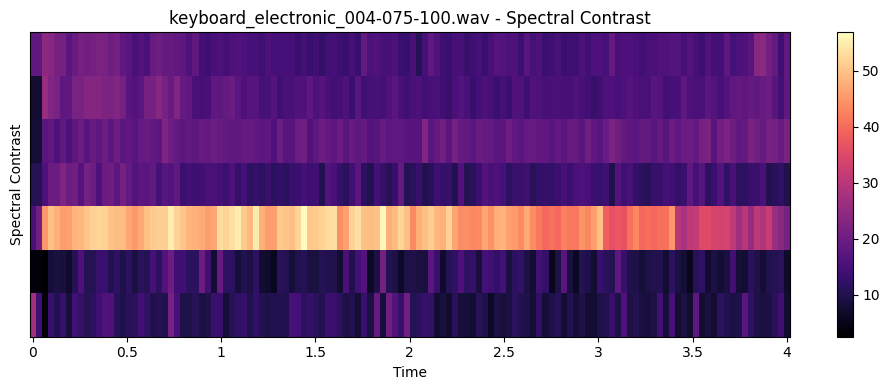


Displaying features for guitar_synthetic_006-018-127.wav:



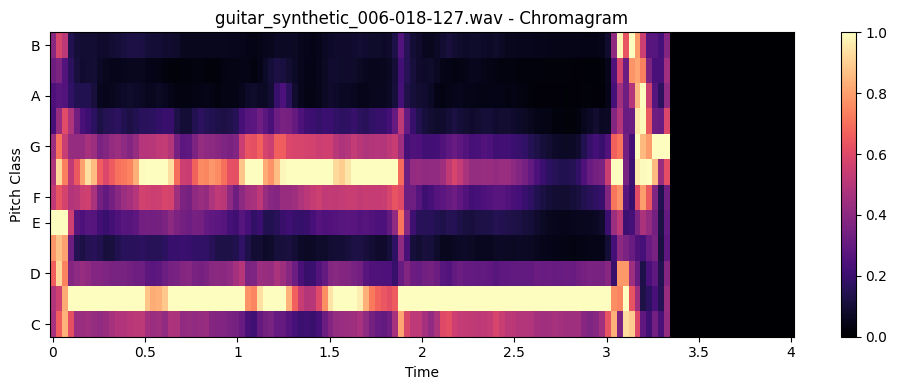

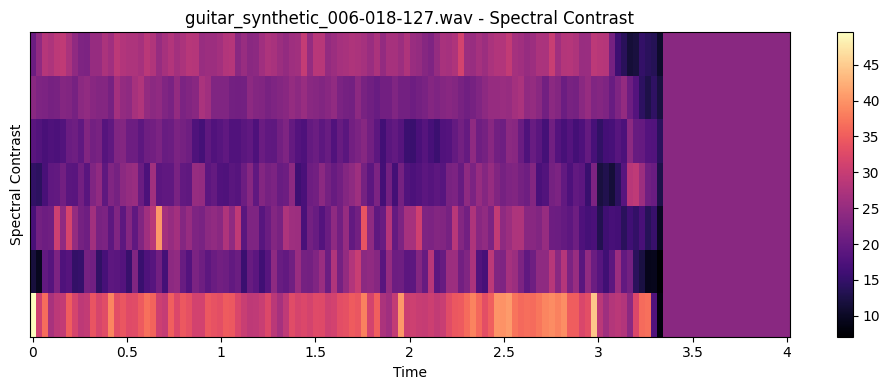

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

# Function to plot MFCCs
def plot_mfcc(audio, sample_rate, title="MFCC"):
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13, hop_length=512)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
    plt.tight_layout()

# Function to plot Chromagram
def plot_chromagram(audio, sample_rate, title="Chromagram"):
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate, hop_length=512, n_chroma=12)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sample_rate)
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Pitch Class")
    plt.tight_layout()

# Function to plot Spectral Contrast
def plot_spectral_contrast(audio, sample_rate, title="Spectral Contrast"):
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate, n_bands=6, hop_length=512, fmin=200.0)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(contrast, x_axis='time', sr=sample_rate)
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Spectral Contrast")
    plt.tight_layout()

# Visualize features for samples in a dataset
def visualize_features(df, sample_count=2):
    for i in range(sample_count):
        audio_sample = df.iloc[i]['audio']
        sample_rate = df.iloc[i]['sample_rate']
        file_name = os.path.basename(df.iloc[i]['file_path'])

        print(f"\nDisplaying features for {file_name}:\n")

        # Plot each feature type
        plot_mfcc(audio_sample, sample_rate, title=f"{file_name} - MFCC")
        plt.show()

        plot_chromagram(audio_sample, sample_rate, title=f"{file_name} - Chromagram")
        plt.show()

        plot_spectral_contrast(audio_sample, sample_rate, title=f"{file_name} - Spectral Contrast")
        plt.show()

# Run feature visualization on samples of the train dataset.
visualize_features(train_audio_df, sample_count=5)

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.stats import zscore

def analyze_audio_harmonics(audio, sample_rate, n_partials=10, dynamic_threshold=0.2):
    """
    Comprehensive audio analysis including fundamental frequency, partials, harmonics,
    and noise-to-tonal ratio calculation.

    Parameters:
    audio (ndarray): The audio signal
    sample_rate (int): Sampling rate of the audio
    n_partials (int): Number of partials to analyze
    dynamic_threshold (float): Minimum amplitude threshold as fraction of strongest harmonic

    Returns:
    dict: Analysis results including frequencies, amplitudes, and noise ratio
    """
    # Constants
    N_MELS = 128
    FMAX = 8000
    HOP_LENGTH = 512

    # Calculate STFT for both spectrogram and noise analysis
    D = librosa.stft(audio, hop_length=HOP_LENGTH)
    S_complex = np.abs(D)

    # Generate mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=N_MELS,
                                     fmax=FMAX, hop_length=HOP_LENGTH)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Detect pitches and magnitudes
    pitches, magnitudes = librosa.piptrack(y=audio, sr=sample_rate,
                                         hop_length=HOP_LENGTH, fmin=20, fmax=FMAX)

    # Calculate frame-wise mean magnitudes
    avg_magnitudes = np.mean(magnitudes, axis=1)
    fundamental_idx = np.argmax(avg_magnitudes)
    fundamental_freq = pitches[fundamental_idx][np.argmax(magnitudes[fundamental_idx])]

    # Calculate noise-to-tonal ratio
    # Using spectral flatness as a measure of noise vs. tonal content
    spectral_flatness = librosa.feature.spectral_flatness(y=audio)
    noise_tonal_ratio = np.mean(spectral_flatness)  # 0 = purely tonal, 1 = purely noisy

    # Determine amplitude threshold
    max_amplitude = np.max(avg_magnitudes)
    amplitude_threshold = max_amplitude * dynamic_threshold

    # Analyze partials and harmonics
    partials = []
    for partial_idx in range(1, n_partials + 1):
        expected_freq = fundamental_freq * partial_idx
        if expected_freq >= FMAX:
            break

        # Find the actual frequency peak near the expected harmonic
        freq_window = 0.1 * expected_freq  # 10% tolerance window
        freq_range = np.where((pitches >= expected_freq - freq_window) &
                            (pitches <= expected_freq + freq_window))

        if len(freq_range[0]) > 0:
            # Get the strongest magnitude in this frequency range
            max_mag_idx = np.unravel_index(
                np.argmax(magnitudes[freq_range]), freq_range[0].shape)
            actual_freq = pitches[freq_range[0][max_mag_idx[0]]][freq_range[1][max_mag_idx[0]]]
            magnitude = magnitudes[freq_range[0][max_mag_idx[0]]][freq_range[1][max_mag_idx[0]]]

            # Calculate harmonicity
            frequency_ratio = actual_freq / fundamental_freq
            is_harmonic = np.abs(frequency_ratio - round(frequency_ratio)) < 0.05

            if magnitude >= amplitude_threshold:
                partials.append({
                    'frequency': actual_freq,
                    'expected_freq': expected_freq,
                    'magnitude': magnitude,
                    'is_harmonic': is_harmonic,
                    'harmonic_number': partial_idx
                })

    # Plotting
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(S_dB, sr=sample_rate, hop_length=HOP_LENGTH,
                           x_axis='time', y_axis='mel', cmap='magma', fmax=FMAX)
    plt.colorbar(format='%+2.0f dB')

    # Title including noise-to-tonal ratio
    plt.title(f"Harmonic Analysis (Noise/Tonal Ratio: {noise_tonal_ratio:.3f})")

    # Annotate fundamental
    plt.axhline(y=fundamental_freq, color='lime', linestyle='--', alpha=0.8,
               label=f'F0: {fundamental_freq:.1f} Hz')

    # Annotate partials
    for partial in partials:
        color = 'yellow' if partial['is_harmonic'] else 'red'
        plt.axhline(y=partial['frequency'], color=color, linestyle='--', alpha=0.5)

        # Label format: Frequency (Expected) - Amplitude
        label_text = f"H{partial['harmonic_number']}: {partial['frequency']:.1f} Hz\n" \
                    f"(Exp: {partial['expected_freq']:.1f} Hz)\n" \
                    f"Amp: {partial['magnitude']:.2f}"

        plt.text(0.02, partial['frequency'], label_text,
                color='white', fontsize=8, ha='left', va='center',
                bbox=dict(facecolor='black', alpha=0.7, edgecolor='none'))

    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # Play audio
    display(Audio(data=audio, rate=sample_rate))

    # Print analysis results
    print(f"\nAnalysis Results:")
    print(f"Fundamental Frequency: {fundamental_freq:.2f} Hz")
    print(f"Noise/Tonal Ratio: {noise_tonal_ratio:.3f}")
    print(f"\nPartials Analysis:")
    for partial in partials:
        print(f"Harmonic {partial['harmonic_number']}:")
        print(f"  Frequency: {partial['frequency']:.2f} Hz")
        print(f"  Expected: {partial['expected_freq']:.2f} Hz")
        print(f"  Magnitude: {partial['magnitude']:.2f}")
        print(f"  Is Harmonic: {partial['is_harmonic']}")

    return {
        'fundamental_freq': fundamental_freq,
        'noise_tonal_ratio': noise_tonal_ratio,
        'partials': partials
    }

Number of valid samples: 28920
                                               audio  sample_rate
0  [-0.0018005371, -0.014831543, -0.0031433105, 0...        16000
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        16000
2  [0.00030517578, -0.00039672852, 0.0005187988, ...        16000
3  [0.0, 0.0, 0.0, 0.0, -3.0517578e-05, 3.0517578...        16000
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        16000

Analyzing Sample 0...


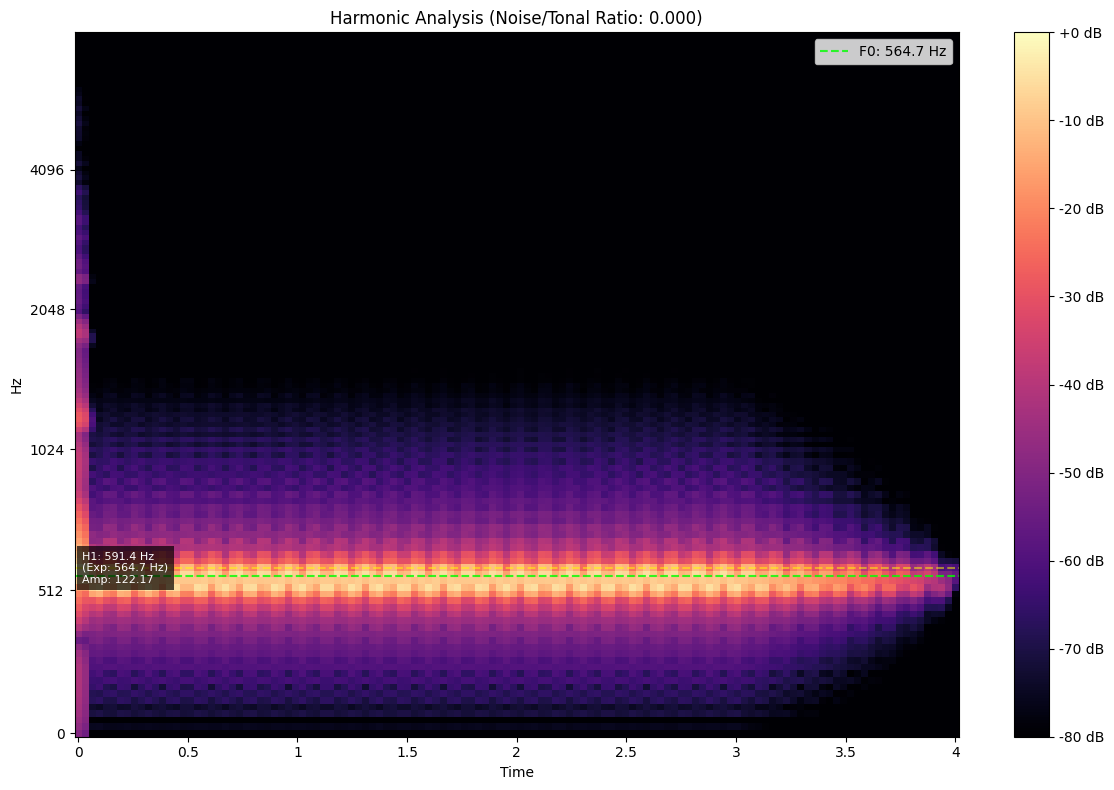


Analysis Results:
Fundamental Frequency: 564.66 Hz
Noise/Tonal Ratio: 0.000

Partials Analysis:
Harmonic 1:
  Frequency: 591.38 Hz
  Expected: 564.66 Hz
  Magnitude: 122.17
  Is Harmonic: True

Analyzing Sample 1...


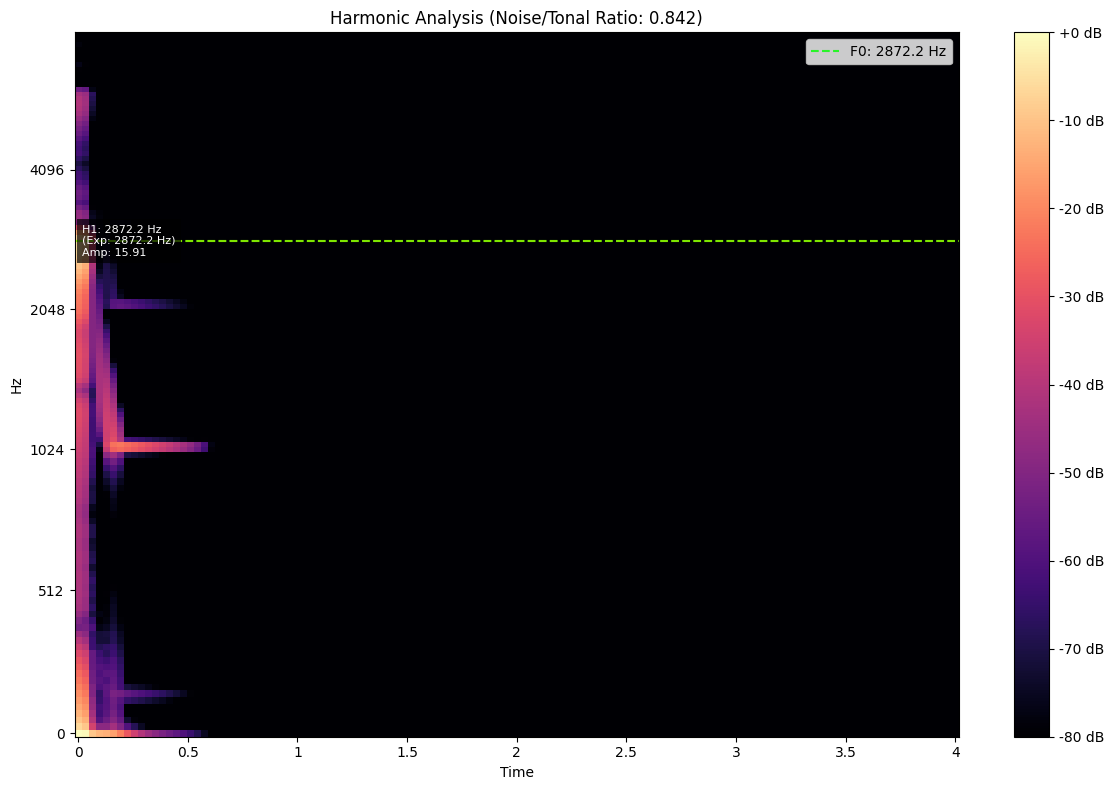


Analysis Results:
Fundamental Frequency: 2872.24 Hz
Noise/Tonal Ratio: 0.842

Partials Analysis:
Harmonic 1:
  Frequency: 2872.24 Hz
  Expected: 2872.24 Hz
  Magnitude: 15.91
  Is Harmonic: True

Analyzing Sample 2...


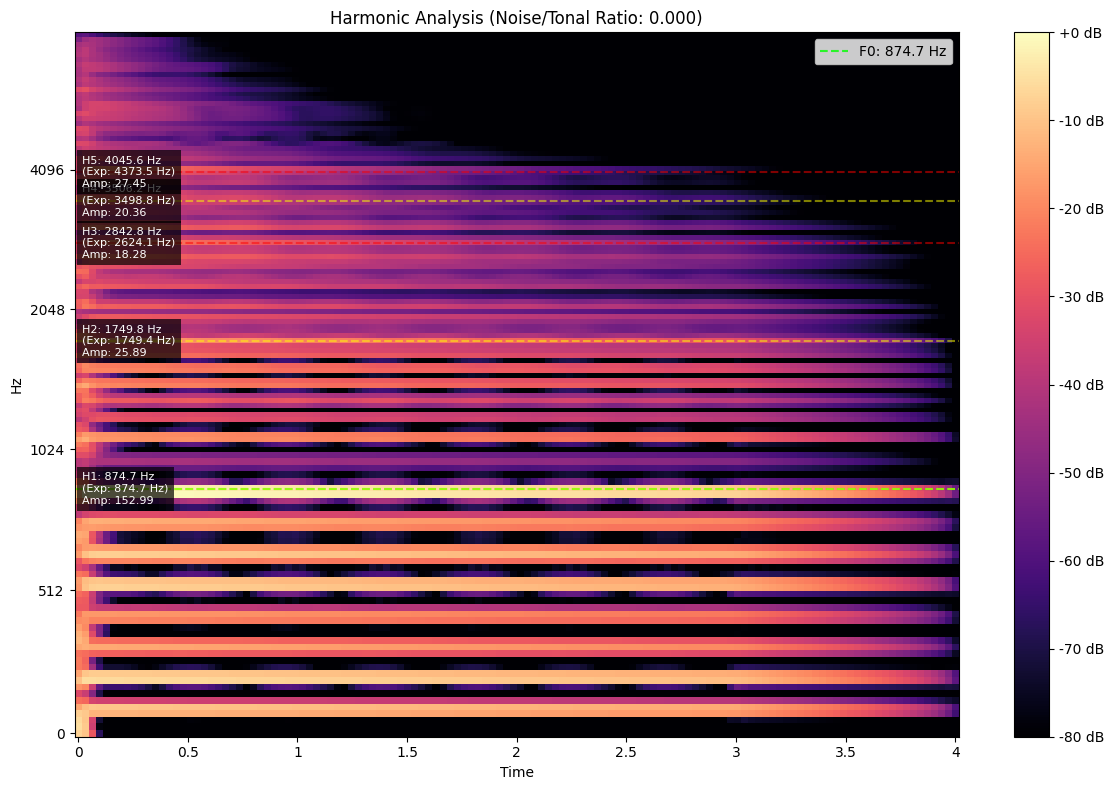


Analysis Results:
Fundamental Frequency: 874.70 Hz
Noise/Tonal Ratio: 0.000

Partials Analysis:
Harmonic 1:
  Frequency: 874.70 Hz
  Expected: 874.70 Hz
  Magnitude: 152.99
  Is Harmonic: True
Harmonic 2:
  Frequency: 1749.84 Hz
  Expected: 1749.40 Hz
  Magnitude: 25.89
  Is Harmonic: True
Harmonic 3:
  Frequency: 2842.84 Hz
  Expected: 2624.10 Hz
  Magnitude: 18.28
  Is Harmonic: False
Harmonic 4:
  Frequency: 3506.19 Hz
  Expected: 3498.80 Hz
  Magnitude: 20.36
  Is Harmonic: True
Harmonic 5:
  Frequency: 4045.56 Hz
  Expected: 4373.50 Hz
  Magnitude: 27.45
  Is Harmonic: False

Analyzing Sample 3...


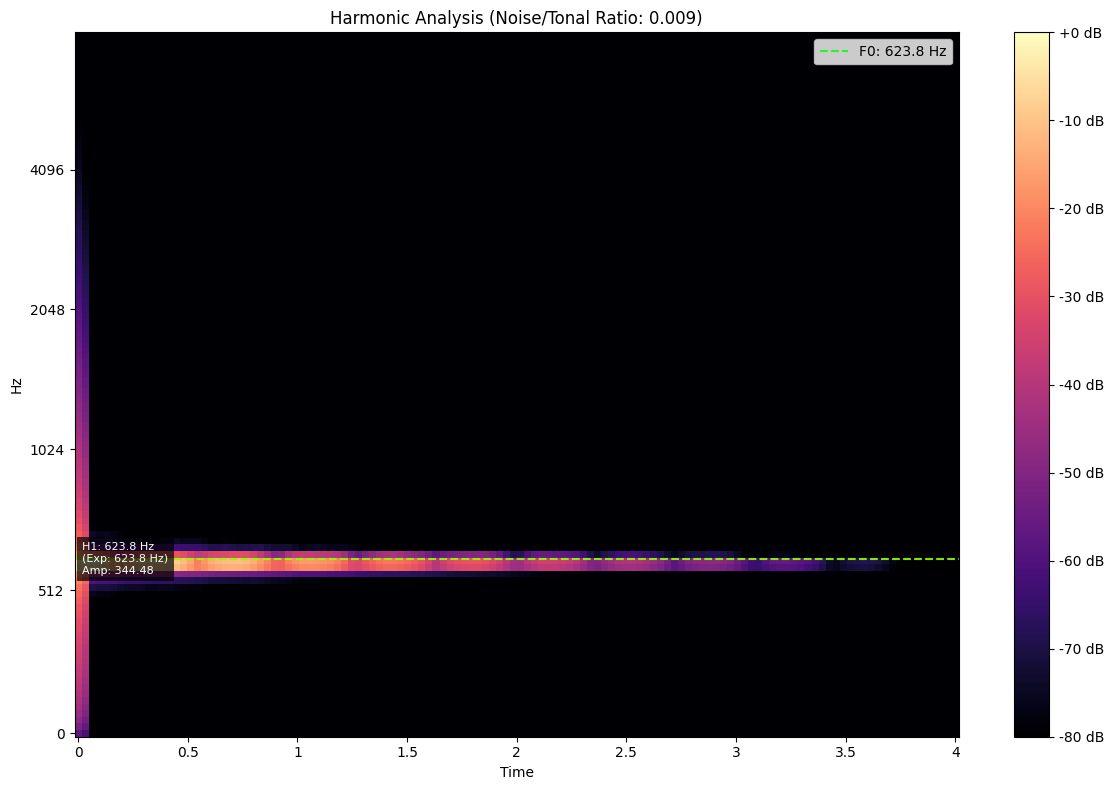


Analysis Results:
Fundamental Frequency: 623.85 Hz
Noise/Tonal Ratio: 0.009

Partials Analysis:
Harmonic 1:
  Frequency: 623.85 Hz
  Expected: 623.85 Hz
  Magnitude: 344.48
  Is Harmonic: True

Analyzing Sample 4...


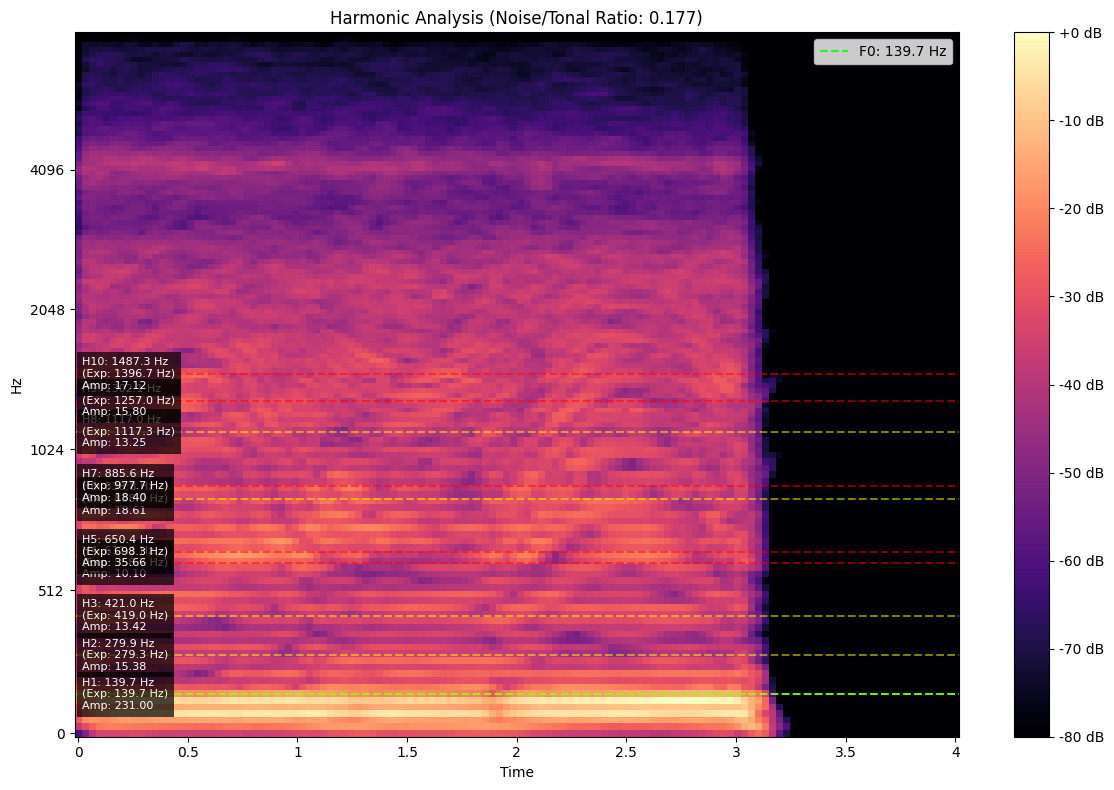


Analysis Results:
Fundamental Frequency: 139.67 Hz
Noise/Tonal Ratio: 0.177

Partials Analysis:
Harmonic 1:
  Frequency: 139.67 Hz
  Expected: 139.67 Hz
  Magnitude: 231.00
  Is Harmonic: True
Harmonic 2:
  Frequency: 279.90 Hz
  Expected: 279.33 Hz
  Magnitude: 15.38
  Is Harmonic: True
Harmonic 3:
  Frequency: 420.99 Hz
  Expected: 419.00 Hz
  Magnitude: 13.42
  Is Harmonic: True
Harmonic 4:
  Frequency: 611.14 Hz
  Expected: 558.67 Hz
  Magnitude: 10.10
  Is Harmonic: False
Harmonic 5:
  Frequency: 650.44 Hz
  Expected: 698.33 Hz
  Magnitude: 35.66
  Is Harmonic: False
Harmonic 6:
  Frequency: 838.76 Hz
  Expected: 838.00 Hz
  Magnitude: 18.61
  Is Harmonic: True
Harmonic 7:
  Frequency: 885.64 Hz
  Expected: 977.66 Hz
  Magnitude: 18.40
  Is Harmonic: False
Harmonic 8:
  Frequency: 1117.00 Hz
  Expected: 1117.33 Hz
  Magnitude: 13.25
  Is Harmonic: True
Harmonic 9:
  Frequency: 1302.12 Hz
  Expected: 1257.00 Hz
  Magnitude: 15.80
  Is Harmonic: False
Harmonic 10:
  Frequency: 1487

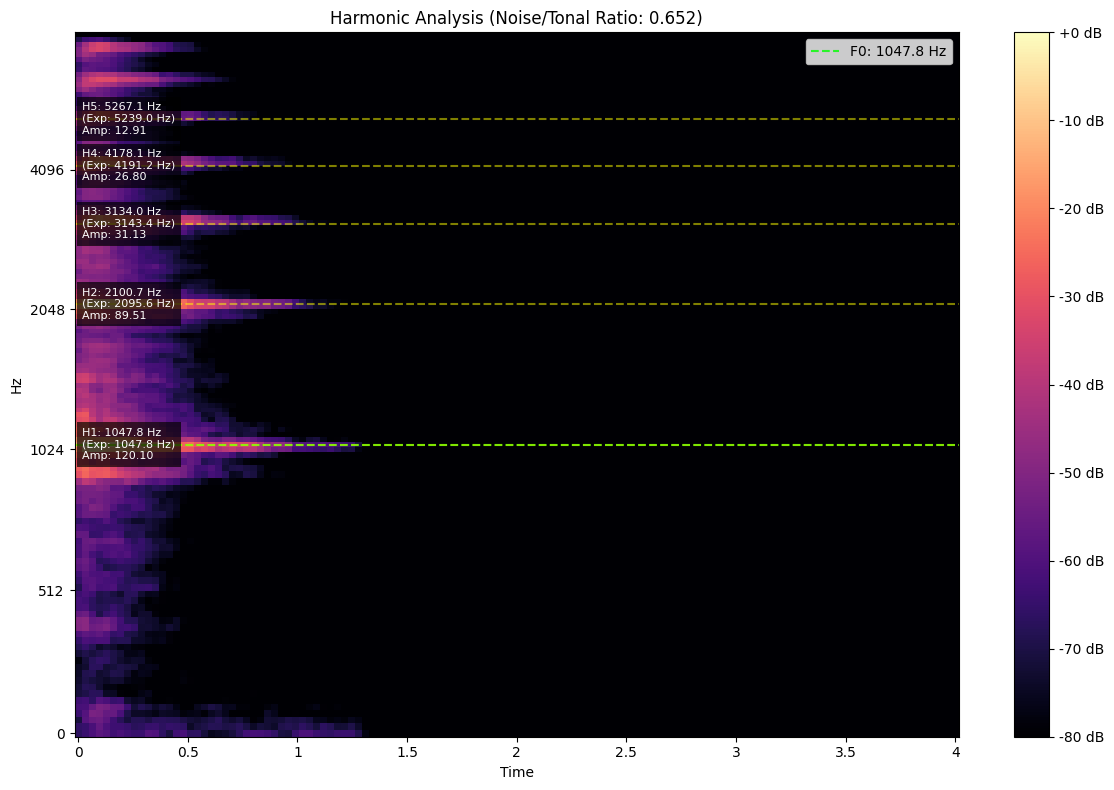


Analysis Results:
Fundamental Frequency: 1047.81 Hz
Noise/Tonal Ratio: 0.652

Partials Analysis:
Harmonic 1:
  Frequency: 1047.81 Hz
  Expected: 1047.81 Hz
  Magnitude: 120.10
  Is Harmonic: True
Harmonic 2:
  Frequency: 2100.75 Hz
  Expected: 2095.61 Hz
  Magnitude: 89.51
  Is Harmonic: True
Harmonic 3:
  Frequency: 3134.00 Hz
  Expected: 3143.42 Hz
  Magnitude: 31.13
  Is Harmonic: True
Harmonic 4:
  Frequency: 4178.06 Hz
  Expected: 4191.23 Hz
  Magnitude: 26.80
  Is Harmonic: True
Harmonic 5:
  Frequency: 5267.12 Hz
  Expected: 5239.03 Hz
  Magnitude: 12.91
  Is Harmonic: True

Analyzing Sample 6...


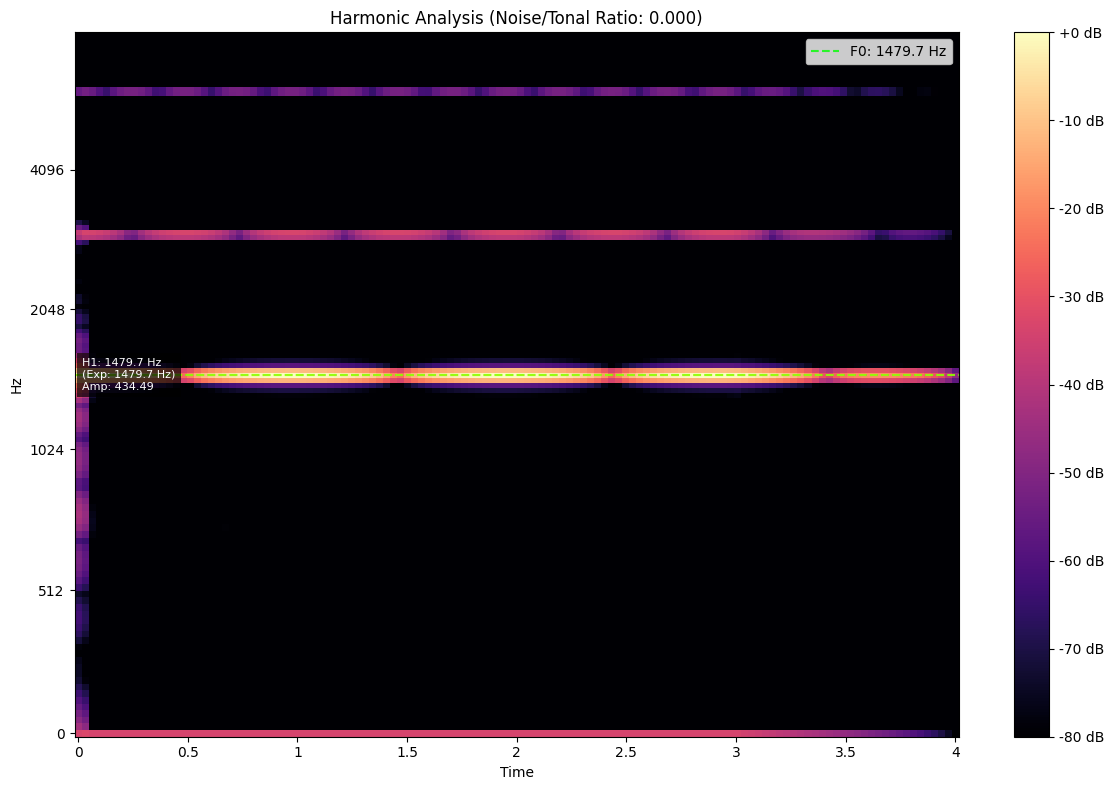


Analysis Results:
Fundamental Frequency: 1479.73 Hz
Noise/Tonal Ratio: 0.000

Partials Analysis:
Harmonic 1:
  Frequency: 1479.73 Hz
  Expected: 1479.73 Hz
  Magnitude: 434.49
  Is Harmonic: True


In [ ]:
def analyze_sample(idx, df):
    """
    Analyzes a single audio sample using harmonic analysis.

    Parameters:
    idx (int): Index of the sample in the DataFrame.
    df (pd.DataFrame): DataFrame containing the audio data.

    Returns:
    None
    """
    try:
        # Verify audio and sample_rate are not empty
        if 'audio' not in df or 'sample_rate' not in df:
            raise KeyError(f"Missing 'audio' or 'sample_rate' for Sample {idx}")

        audio = df.iloc[idx]['audio']
        sample_rate = df.iloc[idx]['sample_rate']

        # Ensure audio data is valid
        if audio is None or len(audio) == 0:
            raise ValueError(f"Audio data is empty for Sample {idx}")

        print(f"\nAnalyzing Sample {idx}...")

        # Use analysis function
        analyze_audio_harmonics(
            audio=audio,
            sample_rate=sample_rate,
            n_partials=10,
            dynamic_threshold=0.1
        )
    except KeyError as e:
        print(f"Key Error for Sample {idx}: {e}")
    except ValueError as e:
        print(f"Value Error for Sample {idx}: {e}")
    except Exception as e:
        print(f"Error analyzing Sample {idx}: {e}")

# Verify dataset integrity
train_audio_df = train_audio_df.reset_index(drop=True)

# Check for valid entries
print(f"Number of valid samples: {len(train_audio_df)}")
print(train_audio_df[['audio', 'sample_rate']].head())

# Annotate the first 7 samples
max_samples = min(7, len(train_audio_df))
for idx in range(max_samples):
    analyze_sample(idx, train_audio_df)

## Data Preprocessing

In [ ]:
import numpy as np
import cv2
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Constants
IMAGE_SIZE = (128, 128)
HOP_LENGTH = 512
N_MELS = 128
FMAX = 4096

# Function to create and normalize spectrogram
def create_spectrogram(audio, sample_rate):
    # Generate the mel spectrogram
    S = librosa.feature.melspectrogram(y=audio,
                                       sr=sample_rate,
                                       n_mels=N_MELS,
                                       fmax=FMAX,
                                       hop_length=HOP_LENGTH)
    S_dB = librosa.power_to_db(S, ref=np.max)
    # Normalize to range [0, 1]
    S_dB_normalized = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())
    # Resize to IMAGE_SIZE
    S_dB_resized = cv2.resize(S_dB_normalized, IMAGE_SIZE)
    return S_dB_resized

# Function to create and normalize MFCC
def create_mfcc(audio, sample_rate):
    mfccs = librosa.feature.mfcc(y=audio,
                                 sr=sample_rate,
                                 n_mfcc=13,
                                 hop_length=HOP_LENGTH)
    # Normalize to range [0, 1]
    mfccs_normalized = (mfccs - mfccs.min()) / (mfccs.max() - mfccs.min())
    # Resize to IMAGE_SIZE
    mfccs_resized = cv2.resize(mfccs_normalized, IMAGE_SIZE)
    return mfccs_resized

# Data preparation function for a DataFrame
def prepare_data(df):
    spectrograms = []
    mfccs = []

    for i, row in df.iterrows():
        audio = row['audio']
        sample_rate = row['sample_rate']

        # Create and normalize spectrogram and MFCC
        spectrogram = create_spectrogram(audio, sample_rate)
        mfcc = create_mfcc(audio, sample_rate)

        spectrograms.append(spectrogram)
        mfccs.append(mfcc)

    # Convert lists to numpy arrays and add channel dimension (for CNN input)
    spectrograms = np.array(spectrograms)[..., np.newaxis]
    mfccs = np.array(mfccs)[..., np.newaxis]

    return spectrograms, mfccs

# Ensure we're using the set sampled data amount
print(f"Percentage of Dataset Used: {sample_fraction * 100}%")

# Prepare data for train, validation, and test sets using the merged DataFrames
train_spectrograms, train_mfccs = prepare_data(train_audio_df)
test_spectrograms, test_mfccs = prepare_data(test_audio_df)
valid_spectrograms, valid_mfccs = prepare_data(valid_audio_df)

# Confirm the shapes of the prepared data
print("Train Spectrograms Shape:", train_spectrograms.shape)
print("Train MFCCs Shape:", train_mfccs.shape)
print("Test Spectrograms Shape:", test_spectrograms.shape)
print("Test MFCCs Shape:", test_mfccs.shape)
print("Validation Spectrograms Shape:", valid_spectrograms.shape)
print("Validation MFCCs Shape:", valid_mfccs.shape)

Percentage of Dataset Used: 10.0%
Train Spectrograms Shape: (28920, 128, 128, 1)
Train MFCCs Shape: (28920, 128, 128, 1)
Test Spectrograms Shape: (409, 128, 128, 1)
Test MFCCs Shape: (409, 128, 128, 1)
Validation Spectrograms Shape: (1267, 128, 128, 1)
Validation MFCCs Shape: (1267, 128, 128, 1)


##Labels

In [ ]:
# Extract unique instrument families from the combined training data
instrument_classes = list(combined_train_df['instrument_family_str'].unique())
num_instruments = len(instrument_classes)  # This is number of instrument classes

# Create a mapping from instrument name to index
instrument_to_index = {name: idx for idx, name in enumerate(instrument_classes)}

# Apply this mapping to create labels in train, validation, and test samples
combined_train_df['instrument_label'] = combined_train_df['instrument_family_str'].map(instrument_to_index)
combined_valid_df['instrument_label'] = combined_valid_df['instrument_family_str'].map(instrument_to_index)
combined_test_df['instrument_label'] = combined_test_df['instrument_family_str'].map(instrument_to_index)

# One-hot encode instrument labels for each dataset
from tensorflow.keras.utils import to_categorical
y_instruments_train = to_categorical(combined_train_df['instrument_label'], num_classes=num_instruments)
y_instruments_val = to_categorical(combined_valid_df['instrument_label'], num_classes=num_instruments)
y_instruments_test = to_categorical(combined_test_df['instrument_label'], num_classes=num_instruments)

# Print shapes of one-hot encoded labels
print("Shape of y_instruments_train:", y_instruments_train.shape)
print("Shape of y_instruments_val:", y_instruments_val.shape)
print("Shape of y_instruments_test:", y_instruments_test.shape)

# Print first few samples of one-hot encoded labels
print("\nSample of one-hot encoded labels (Train):")
print(y_instruments_train[:5])
print("\nSample of one-hot encoded labels (Validation):")
print(y_instruments_val[:5])
print("\nSample of one-hot encoded labels (Test):")
print(y_instruments_test[:5])

Shape of y_instruments_train: (28920, 11)
Shape of y_instruments_val: (1267, 11)
Shape of y_instruments_test: (409, 11)

Sample of one-hot encoded labels (Train):
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

Sample of one-hot encoded labels (Validation):
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

Sample of one-hot encoded labels (Test):
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


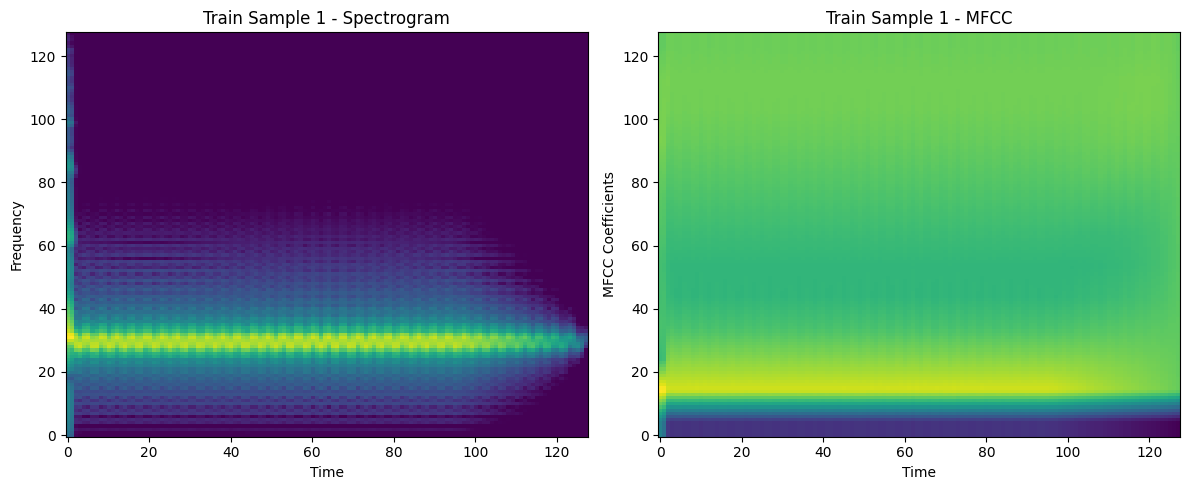

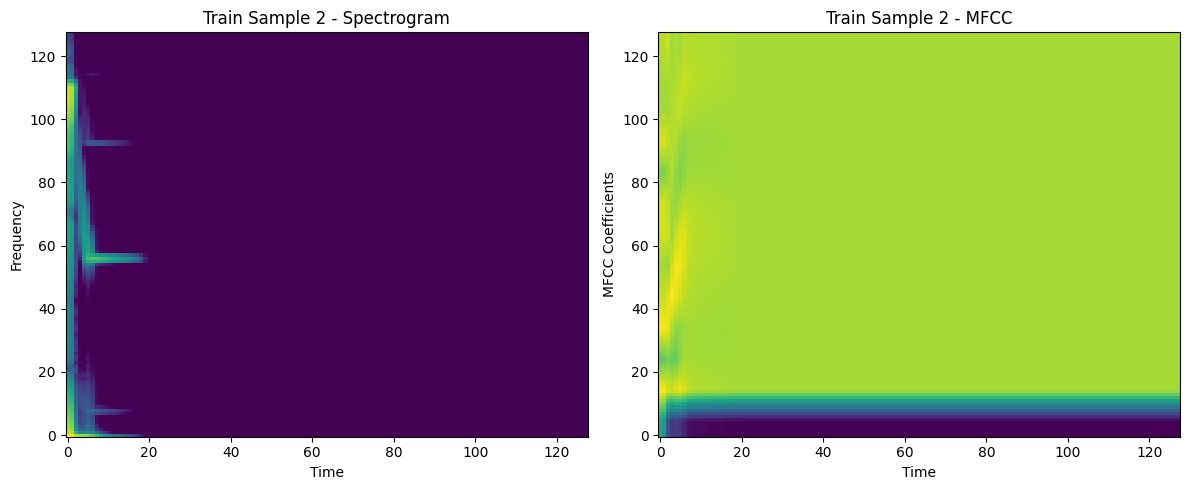

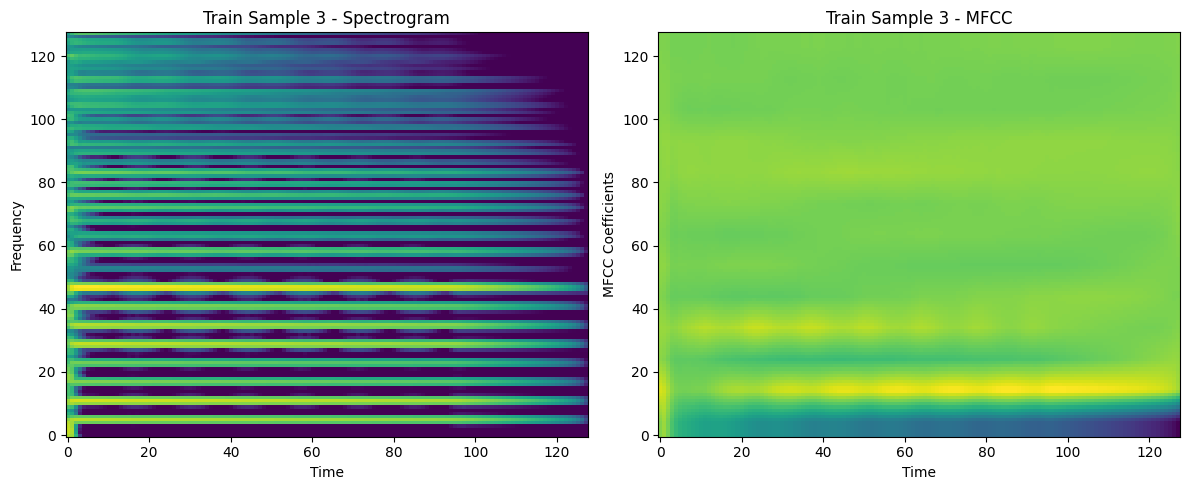

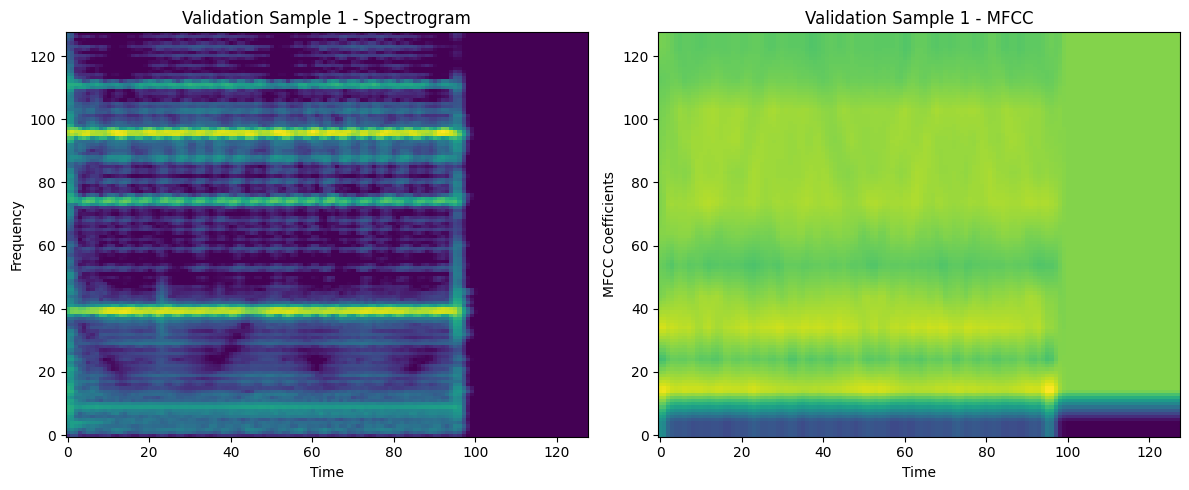

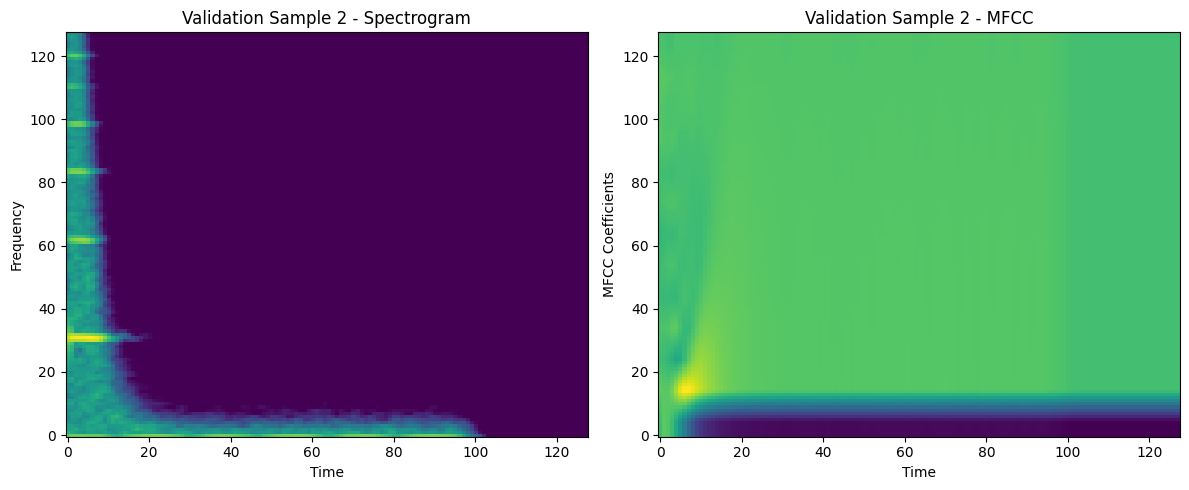

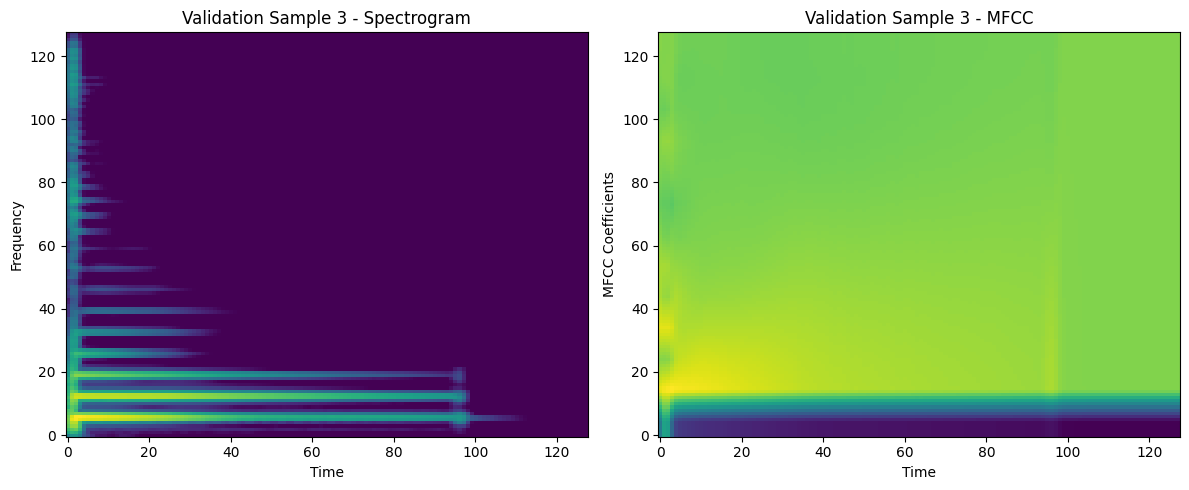

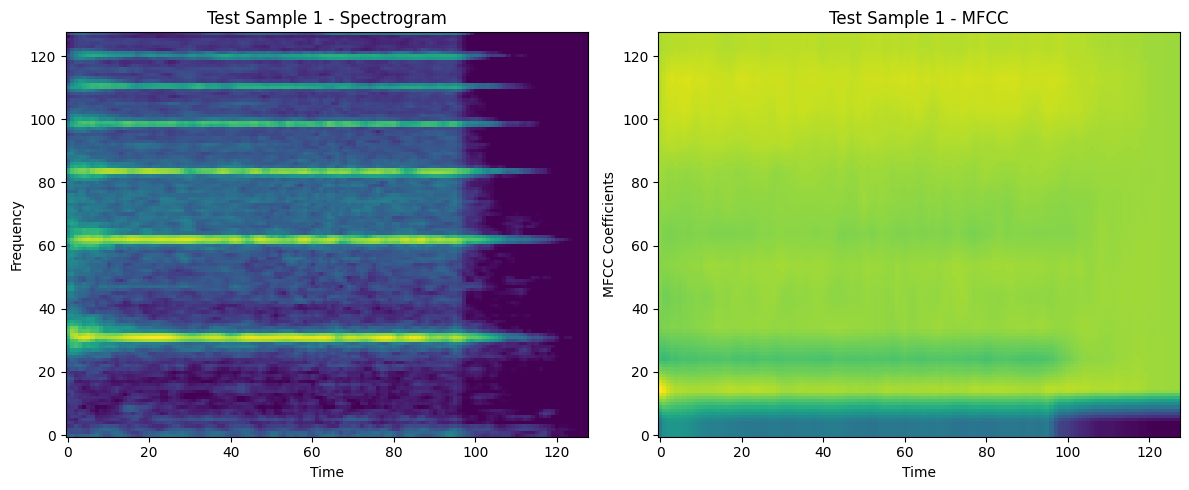

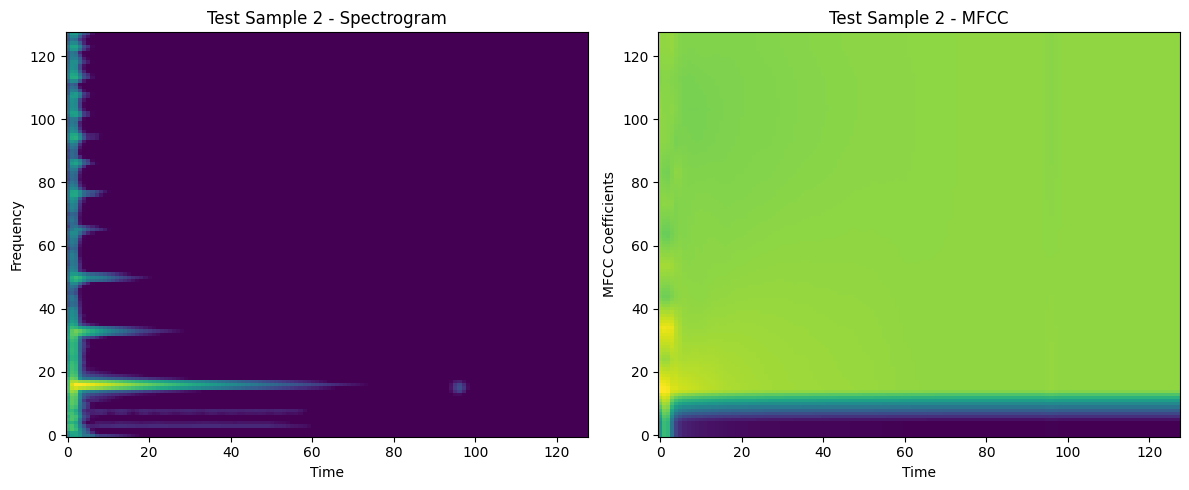

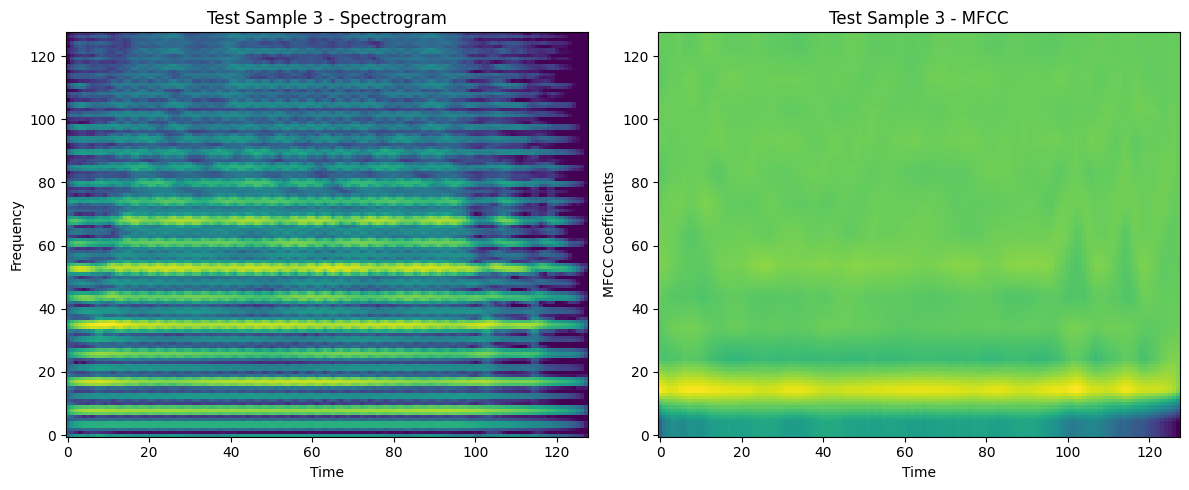

In [ ]:
# Function to plot spectrogram and MFCC for a sample
def plot_spectrogram_and_mfcc(spectrogram, mfcc, title_prefix="Sample"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot spectrogram
    axs[0].imshow(spectrogram.squeeze(), aspect='auto', origin='lower', cmap='viridis')
    axs[0].set_title(f"{title_prefix} - Spectrogram")
    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("Frequency")

    # Plot MFCC
    axs[1].imshow(mfcc.squeeze(), aspect='auto', origin='lower', cmap='viridis')
    axs[1].set_title(f"{title_prefix} - MFCC")
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("MFCC Coefficients")

    plt.tight_layout()
    plt.show()

# Visualize a few samples from the train set
for i in range(3):
    plot_spectrogram_and_mfcc(train_spectrograms[i],
                              train_mfccs[i],
                              title_prefix=f"Train Sample {i+1}")

# Visualize a few samples from the validation set
for i in range(3):
    plot_spectrogram_and_mfcc(valid_spectrograms[i],
                              valid_mfccs[i],
                              title_prefix=f"Validation Sample {i+1}")

# Visualize a few samples from the test set
for i in range(3):
    plot_spectrogram_and_mfcc(test_spectrograms[i],
                              test_mfccs[i],
                              title_prefix=f"Test Sample {i+1}")

## Model

In [ ]:
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense,
    Dropout, BatchNormalization, concatenate,
    LeakyReLU, Add, GlobalAveragePooling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def create_optimized_model(input_shape=(128, 128, 1),
                         num_instruments=11,
                         num_timbral=10,
                         num_sources=3):

    spectrogram_input = Input(shape=input_shape, name='spectrogram_input')
    mfcc_input = Input(shape=input_shape, name='mfcc_input')

    def create_conv_block(x, filters, kernel_size=(3, 3)):
        x = Conv2D(filters, kernel_size, padding='same',
                  kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPooling2D((2, 2))(x)
        return x

    # Spectrogram branch
    x1 = create_conv_block(spectrogram_input, 64, (5, 5))  # Initial filters
    x1 = Dropout(0.2)(x1)

    x1_skip = x1
    x1 = create_conv_block(x1, 128)  # Middle filters
    x1 = Dropout(0.3)(x1)

    # Residual connection
    x1_skip = Conv2D(128, (1, 1), padding='same')(x1_skip)
    x1_skip = MaxPooling2D((2, 2))(x1_skip)
    x1 = Add()([x1, x1_skip])

    x1 = create_conv_block(x1, 256)  # Final filters
    x1 = Dropout(0.4)(x1)

    # Global pooling for generalization
    x1 = GlobalAveragePooling2D()(x1)

    # Enhanced MFCC branch
    x2 = create_conv_block(mfcc_input, 64)
    x2 = Dropout(0.2)(x2)

    x2 = create_conv_block(x2, 128)
    x2 = Dropout(0.3)(x2)

    x2 = create_conv_block(x2, 256)
    x2 = Dropout(0.4)(x2)
    x2 = GlobalAveragePooling2D()(x2)

    # Feature combination
    combined = concatenate([x1, x2])

    # Shared features
    shared = Dense(256, kernel_regularizer=l2(0.001))(combined)
    shared = BatchNormalization()(shared)
    shared = LeakyReLU(alpha=0.1)(shared)
    shared = Dropout(0.5)(shared)

    # Instrument branch
    instrument_branch = Dense(192, kernel_regularizer=l2(0.001))(shared)
    instrument_branch = BatchNormalization()(instrument_branch)
    instrument_branch = LeakyReLU(alpha=0.1)(instrument_branch)
    instrument_branch = Dropout(0.4)(instrument_branch)

    instrument_branch = Dense(128, kernel_regularizer=l2(0.001))(instrument_branch)
    instrument_branch = BatchNormalization()(instrument_branch)
    instrument_branch = LeakyReLU(alpha=0.1)(instrument_branch)
    instrument_output = Dense(num_instruments, activation='softmax',
                            name='instrument_output')(instrument_branch)

    # Source sound branch
    source_branch = Dense(128, kernel_regularizer=l2(0.002))(shared)
    source_branch = BatchNormalization()(source_branch)
    source_branch = LeakyReLU(alpha=0.1)(source_branch)
    source_branch = Dropout(0.5)(source_branch)

    source_branch = Dense(64, kernel_regularizer=l2(0.002))(source_branch)
    source_branch = BatchNormalization()(source_branch)
    source_branch = LeakyReLU(alpha=0.1)(source_branch)
    source_output = Dense(num_sources, activation='softmax',
                         name='source_output')(source_branch)

    # Timbral branch
    timbral_branch = Dense(64, kernel_regularizer=l2(0.001))(shared)
    timbral_branch = Dropout(0.3)(timbral_branch)
    timbral_output = Dense(num_timbral, activation='sigmoid',
                          name='timbral_output')(timbral_branch)

    return Model(
        inputs=[spectrogram_input, mfcc_input],
        outputs={
            'instrument_output': instrument_output,
            'timbral_output': timbral_output,
            'source_output': source_output
        }
    )

In [ ]:
# All labels are cast to float32 for model
y_instruments_train = y_instruments_train.astype('float32')
y_instruments_val = y_instruments_val.astype('float32')
y_instruments_test = y_instruments_test.astype('float32')

y_timbral_train = y_timbral_train.astype('float32')
y_timbral_val = y_timbral_val.astype('float32')
y_timbral_test = y_timbral_test.astype('float32')

y_source_train = y_source_train.astype('float32')
y_source_val = y_source_val.astype('float32')
y_source_test = y_source_test.astype('float32')

In [ ]:
# Create and compile model
model = create_optimized_model()

# Compile with adjusted parameters
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'instrument_output': 'categorical_crossentropy',
        'timbral_output': 'binary_crossentropy',
        'source_output': 'categorical_crossentropy'
    },
    loss_weights={
        'instrument_output': 1.0,  # Balanced weights
        'timbral_output': 0.7,
        'source_output': 1.2      # Increased weight for source
    },
    metrics={
        'instrument_output': 'accuracy',
        'timbral_output': 'binary_accuracy',
        'source_output': 'accuracy'
    }
)

# Training configuration with larger batch size
history = model.fit(
    [train_spectrograms, train_mfccs],
    {
        'instrument_output': y_instruments_train,
        'timbral_output': y_timbral_train,
        'source_output': y_source_train
    },
    batch_size=64,
    epochs=20,
    validation_data=(
        [valid_spectrograms, valid_mfccs],
        {
            'instrument_output': y_instruments_val,
            'timbral_output': y_timbral_val,
            'source_output': y_source_val
        }
    ),
    verbose=1
)

Epoch 1/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 43s 58ms/step - instrument_output_accuracy: 0.2361 - instrument_output_loss: 2.2376 - loss: 5.8745 - source_output_accuracy: 0.4227 - source_output_loss: 1.3870 - timbral_output_binary_accuracy: 0.7301 - timbral_output_loss: 0.4224 - val_instrument_output_accuracy: 0.0639 - val_instrument_output_loss: 2.8004 - val_loss: 7.4429 - val_source_output_accuracy: 0.4159 - val_source_output_loss: 2.3980 - val_timbral_output_binary_accuracy: 0.8437 - val_timbral_output_loss: 0.4706
Epoch 2/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - instrument_output_accuracy: 0.3601 - instrument_output_loss: 1.7785 - loss: 4.9401 - source_output_accuracy: 0.5456 - source_output_loss: 1.1383 - timbral_output_binary_accuracy: 0.8540 - timbral_output_loss: 0.2672 - val_instrument_output_accuracy: 0.2107 - val_instrument_output_loss: 2.2899 - val_loss: 5.7458 - val_source_output_accuracy: 0.4941 - val_source_output_loss: 1.4400 - val_timbral_output_binary_accuracy: 0.860

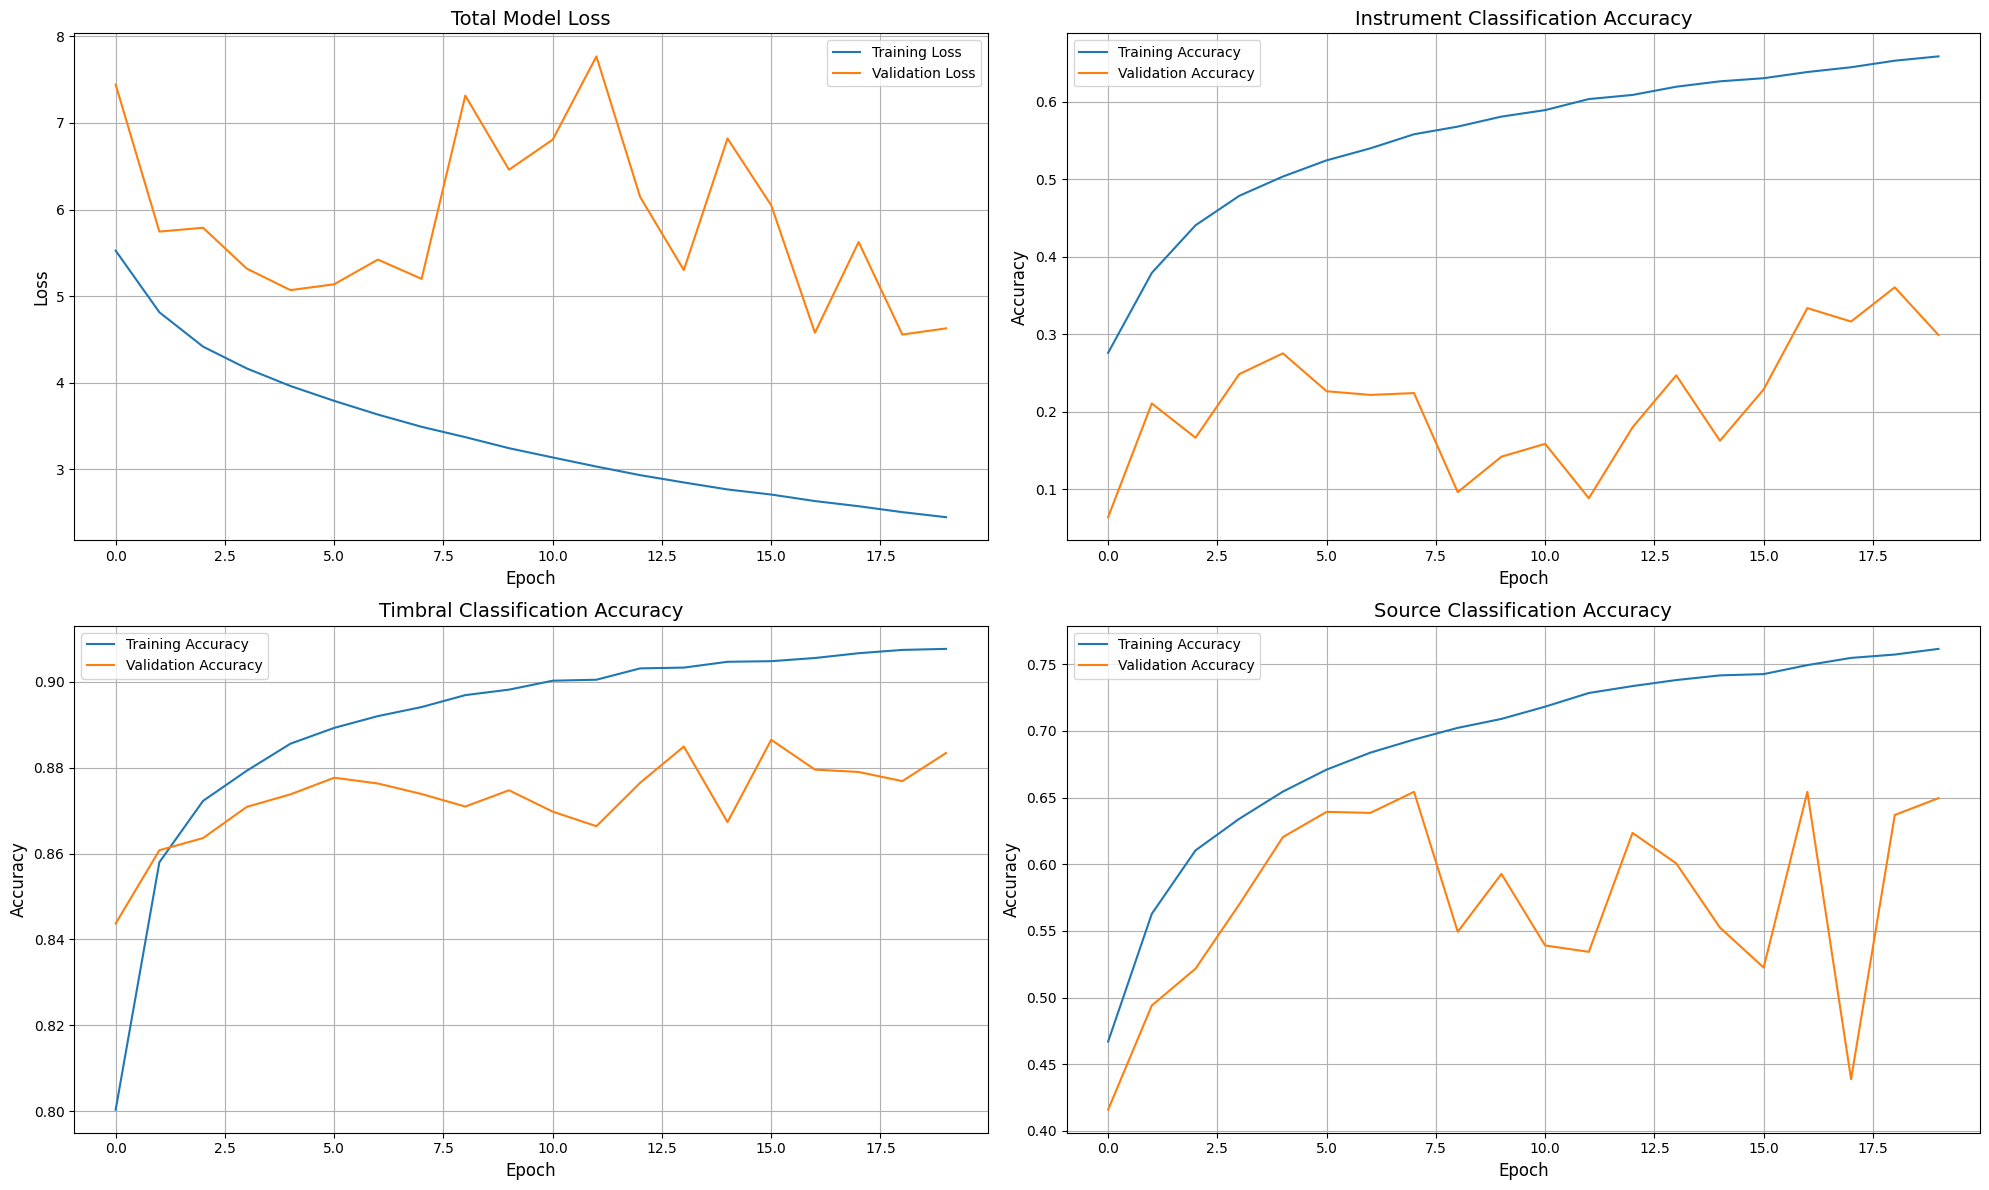


Final Training Metrics:
Total Loss: 2.4478
Instrument Accuracy: 0.6589
Timbral Accuracy: 0.9077
Source Accuracy: 0.7615

Final Validation Metrics:
Validation Loss: 4.6281
Validation Instrument Accuracy: 0.2991
Validation Timbral Accuracy: 0.8834
Validation Source Accuracy: 0.6496


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_multi_output_history(history):
    """
    Plot training history for multi-output model showing loss and accuracy metrics
    """
    # Create figure
    plt.figure(figsize=(20, 12))

    # Plot total loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Total Model Loss', size=14)
    plt.xlabel('Epoch', size=12)
    plt.ylabel('Loss', size=12)
    plt.legend(fontsize=10)
    plt.grid(True)

    # Plot instrument accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history.history['instrument_output_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_instrument_output_accuracy'], label='Validation Accuracy')
    plt.title('Instrument Classification Accuracy', size=14)
    plt.xlabel('Epoch', size=12)
    plt.ylabel('Accuracy', size=12)
    plt.legend(fontsize=10)
    plt.grid(True)

    # Plot timbral accuracy
    plt.subplot(2, 2, 3)
    plt.plot(history.history['timbral_output_binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_timbral_output_binary_accuracy'], label='Validation Accuracy')
    plt.title('Timbral Classification Accuracy', size=14)
    plt.xlabel('Epoch', size=12)
    plt.ylabel('Accuracy', size=12)
    plt.legend(fontsize=10)
    plt.grid(True)

    # Plot source accuracy
    plt.subplot(2, 2, 4)
    plt.plot(history.history['source_output_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_source_output_accuracy'], label='Validation Accuracy')
    plt.title('Source Classification Accuracy', size=14)
    plt.xlabel('Epoch', size=12)
    plt.ylabel('Accuracy', size=12)
    plt.legend(fontsize=10)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("\nFinal Training Metrics:")
    print(f"Total Loss: {history.history['loss'][-1]:.4f}")
    print(f"Instrument Accuracy: {history.history['instrument_output_accuracy'][-1]:.4f}")
    print(f"Timbral Accuracy: {history.history['timbral_output_binary_accuracy'][-1]:.4f}")
    print(f"Source Accuracy: {history.history['source_output_accuracy'][-1]:.4f}")

    print("\nFinal Validation Metrics:")
    print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Validation Instrument Accuracy: {history.history['val_instrument_output_accuracy'][-1]:.4f}")
    print(f"Validation Timbral Accuracy: {history.history['val_timbral_output_binary_accuracy'][-1]:.4f}")
    print(f"Validation Source Accuracy: {history.history['val_source_output_accuracy'][-1]:.4f}")

# Plot learning curves
plot_multi_output_history(history)

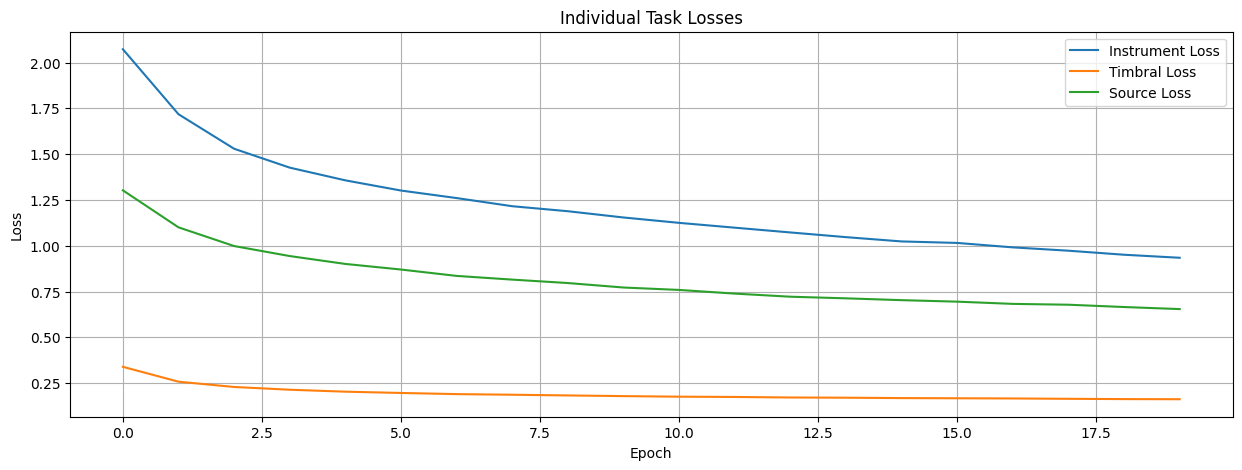

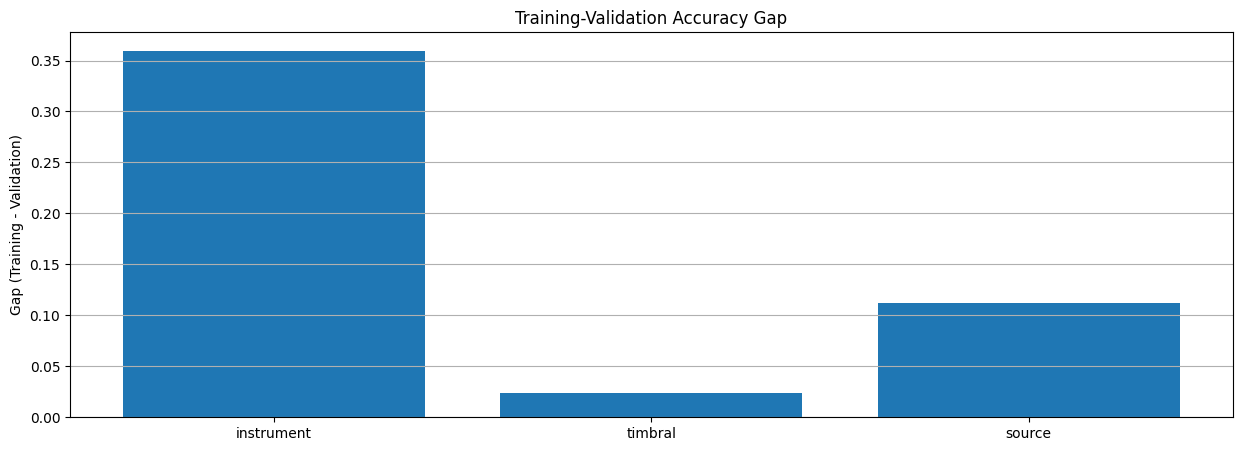

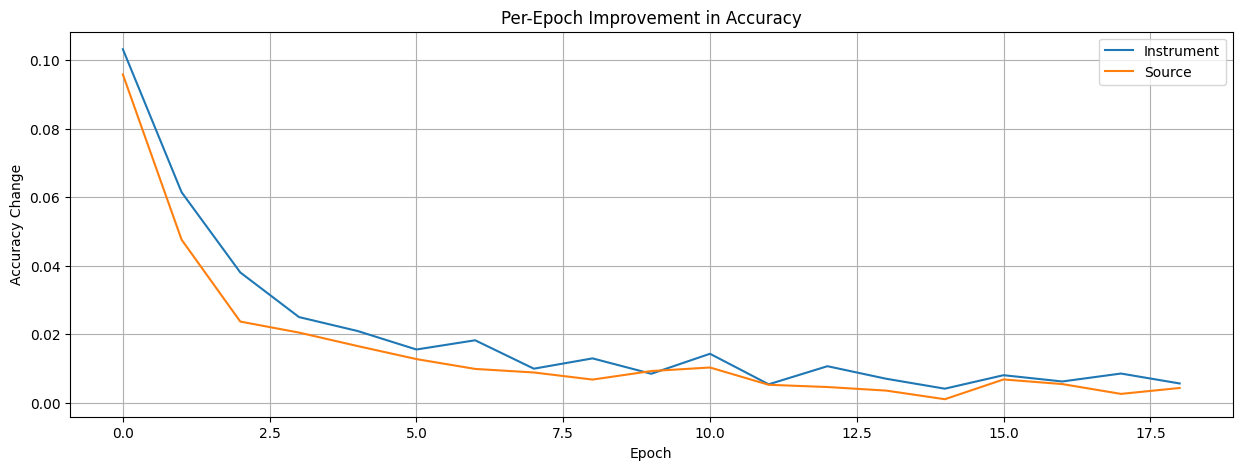

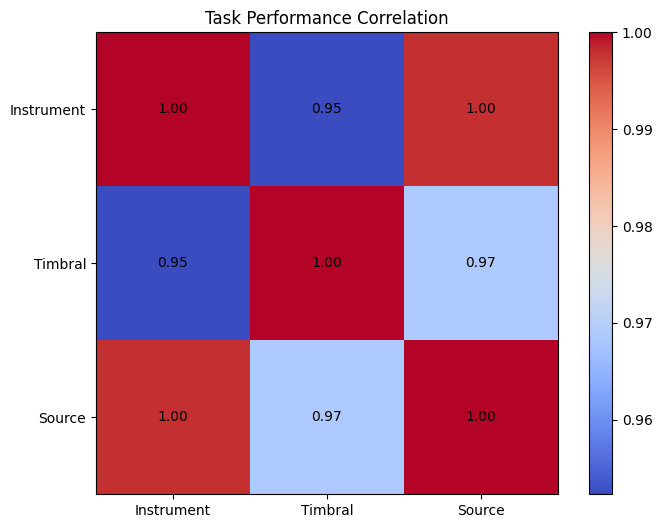


Detailed Performance Statistics:

Instrument Classification:
Max Validation Accuracy: 0.3607
Std Dev of Validation: 0.0796
Validation Stability (last 10 epochs): 0.0849

Timbral Classification:
Max Validation Accuracy: 0.8865
Std Dev of Validation: 0.0094
Validation Stability (last 10 epochs): 0.0068

Source Classification:
Max Validation Accuracy: 0.6543
Std Dev of Validation: 0.0691
Validation Stability (last 10 epochs): 0.0659


In [ ]:
def plot_additional_metrics(history):
    """
    Additional visualizations for model performance analysis
    """
    # 1. Individual Loss Components
    plt.figure(figsize=(15, 5))
    plt.plot(history.history['instrument_output_loss'], label='Instrument Loss')
    plt.plot(history.history['timbral_output_loss'], label='Timbral Loss')
    plt.plot(history.history['source_output_loss'], label='Source Loss')
    plt.title('Individual Task Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Training vs Validation Gap
    plt.figure(figsize=(15, 5))
    tasks = ['instrument', 'timbral', 'source']
    gaps = []
    for task in tasks:
        if task == 'timbral':
            train_acc = history.history[f'{task}_output_binary_accuracy'][-1]
            val_acc = history.history[f'val_{task}_output_binary_accuracy'][-1]
        else:
            train_acc = history.history[f'{task}_output_accuracy'][-1]
            val_acc = history.history[f'val_{task}_output_accuracy'][-1]
        gaps.append(train_acc - val_acc)

    plt.bar(tasks, gaps)
    plt.title('Training-Validation Accuracy Gap')
    plt.ylabel('Gap (Training - Validation)')
    plt.grid(True, axis='y')
    plt.show()

    # 3. Per-Epoch Improvement
    plt.figure(figsize=(15, 5))
    for metric in ['instrument_output_accuracy', 'source_output_accuracy']:
        improvements = np.diff(history.history[metric])
        plt.plot(improvements, label=metric.split('_')[0].capitalize())
    plt.title('Per-Epoch Improvement in Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Change')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Task Correlation Matrix
    plt.figure(figsize=(8, 6))
    metrics = {
        'Instrument': history.history['instrument_output_accuracy'],
        'Timbral': history.history['timbral_output_binary_accuracy'],
        'Source': history.history['source_output_accuracy']
    }
    corr_matrix = np.corrcoef([metrics[k] for k in metrics.keys()])
    plt.imshow(corr_matrix, cmap='coolwarm')
    plt.colorbar()
    plt.xticks(range(len(metrics)), metrics.keys())
    plt.yticks(range(len(metrics)), metrics.keys())
    plt.title('Task Performance Correlation')
    for i in range(len(metrics)):
        for j in range(len(metrics)):
            plt.text(i, j, f'{corr_matrix[i,j]:.2f}',
                    ha='center', va='center')
    plt.show()

# Print summary statistics
def print_detailed_stats(history):
    """
    Print detailed statistics about model performance
    """
    print("\nDetailed Performance Statistics:")

    # Calculate stability metrics
    for task in ['instrument', 'timbral', 'source']:
        if task == 'timbral':
            val_acc = history.history[f'val_{task}_output_binary_accuracy']
        else:
            val_acc = history.history[f'val_{task}_output_accuracy']

        print(f"\n{task.capitalize()} Classification:")
        print(f"Max Validation Accuracy: {max(val_acc):.4f}")
        print(f"Std Dev of Validation: {np.std(val_acc):.4f}")
        print(f"Validation Stability (last 10 epochs): {np.std(val_acc[-10:]):.4f}")

plot_additional_metrics(history)
print_detailed_stats(history)

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


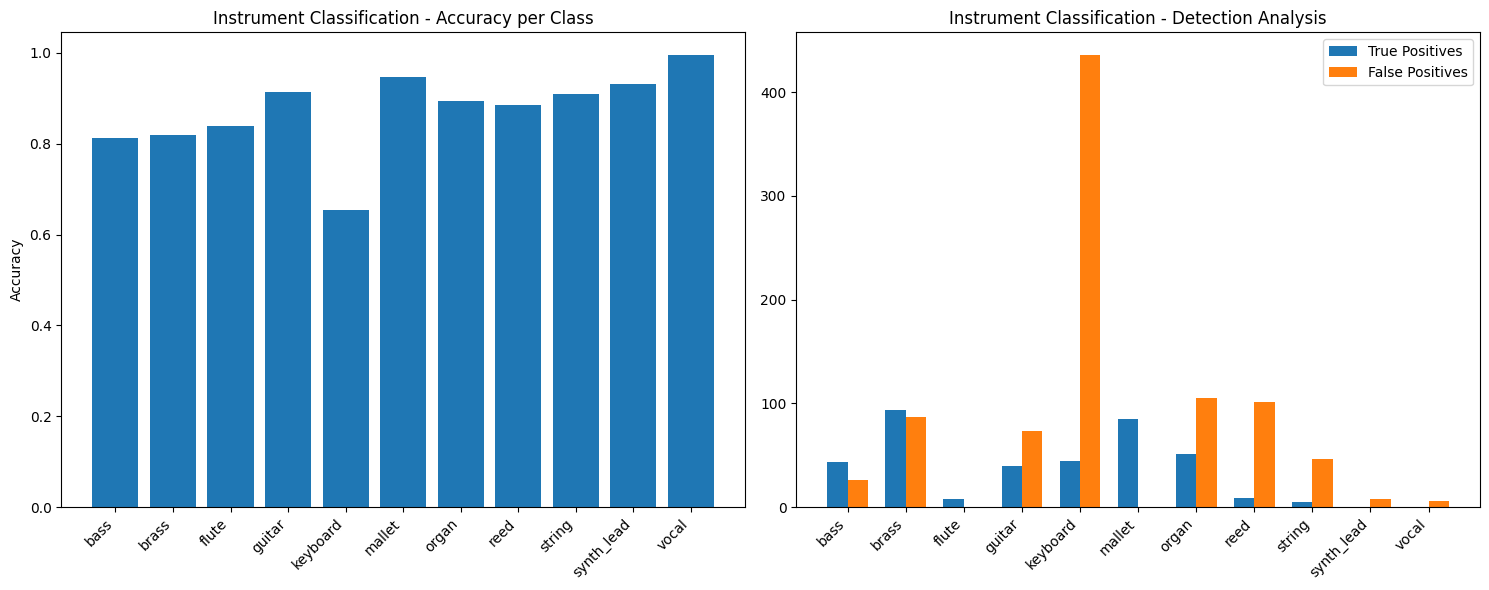


Detailed Instrument Classification Statistics:
--------------------------------------------------

bass:
Accuracy: 0.811
True Positives: 43
False Positives: 26

brass:
Accuracy: 0.820
True Positives: 94
False Positives: 87

flute:
Accuracy: 0.838
True Positives: 8
False Positives: 0

guitar:
Accuracy: 0.915
True Positives: 40
False Positives: 73

keyboard:
Accuracy: 0.654
True Positives: 44
False Positives: 436

mallet:
Accuracy: 0.946
True Positives: 85
False Positives: 0

organ:
Accuracy: 0.893
True Positives: 51
False Positives: 105

reed:
Accuracy: 0.885
True Positives: 9
False Positives: 101

string:
Accuracy: 0.909
True Positives: 5
False Positives: 46

synth_lead:
Accuracy: 0.931
True Positives: 0
False Positives: 8

vocal:
Accuracy: 0.995
True Positives: 0
False Positives: 6


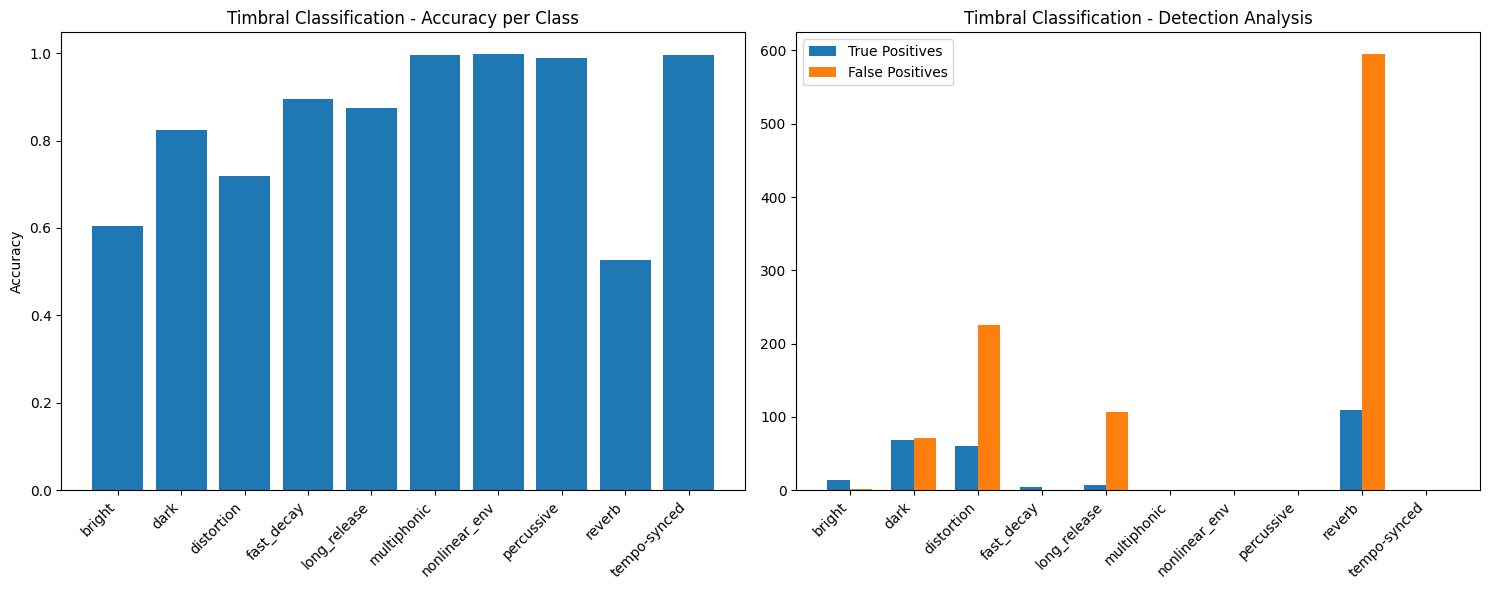


Detailed Timbral Classification Statistics:
--------------------------------------------------

bright:
Accuracy: 0.605
True Positives: 14
False Positives: 2

dark:
Accuracy: 0.825
True Positives: 69
False Positives: 71

distortion:
Accuracy: 0.719
True Positives: 61
False Positives: 226

fast_decay:
Accuracy: 0.894
True Positives: 5
False Positives: 0

long_release:
Accuracy: 0.874
True Positives: 7
False Positives: 107

multiphonic:
Accuracy: 0.995
True Positives: 0
False Positives: 0

nonlinear_env:
Accuracy: 0.998
True Positives: 0
False Positives: 0

percussive:
Accuracy: 0.988
True Positives: 0
False Positives: 0

reverb:
Accuracy: 0.527
True Positives: 110
False Positives: 595

tempo-synced:
Accuracy: 0.995
True Positives: 0
False Positives: 0


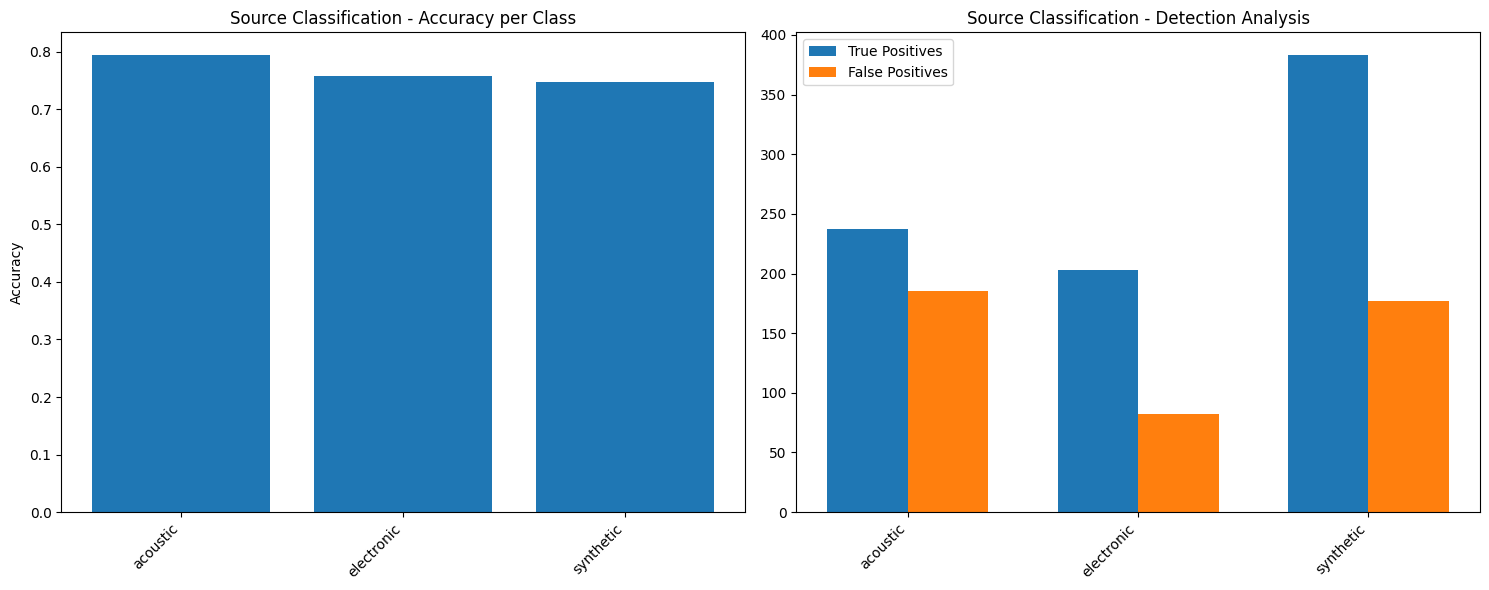


Detailed Source Classification Statistics:
--------------------------------------------------

acoustic:
Accuracy: 0.794
True Positives: 237
False Positives: 185

electronic:
Accuracy: 0.758
True Positives: 203
False Positives: 82

synthetic:
Accuracy: 0.747
True Positives: 383
False Positives: 177


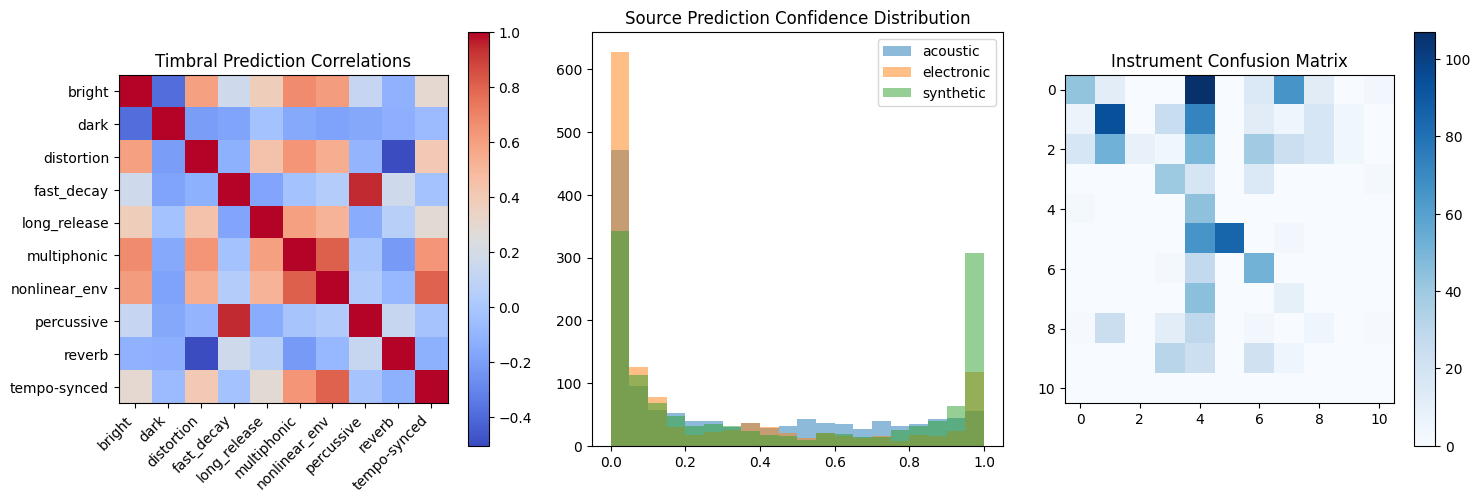

In [ ]:
def plot_comprehensive_analysis(model, val_data, y_instruments_val, y_timbral_val, y_source_val):
    """
    Comprehensive analysis of all three classification tasks
    """
    # Define labels for each category
    instrument_names = [
        'bass', 'brass', 'flute', 'guitar', 'keyboard',
        'mallet', 'organ', 'reed', 'string', 'synth_lead', 'vocal'
    ]

    timbral_qualities = [
        'bright', 'dark', 'distortion', 'fast_decay', 'long_release',
        'multiphonic', 'nonlinear_env', 'percussive', 'reverb', 'tempo-synced'
    ]

    source_types = ['acoustic', 'electronic', 'synthetic']

    # Get predictions
    predictions = model.predict(val_data)
    instrument_pred = predictions['instrument_output']
    timbral_pred = predictions['timbral_output']
    source_pred = predictions['source_output']

    def plot_category_performance(predictions, true_values, labels, title, threshold=0.5):
        plt.figure(figsize=(15, 6))

        # Calculate metrics per class
        accuracies = []
        true_positives = []
        false_positives = []

        for i, label in enumerate(labels):
            if len(predictions.shape) == 2:  # For multi-class (instruments/source)
                pred_class = np.argmax(predictions, axis=1) == i
                true_class = np.argmax(true_values, axis=1) == i
            else:  # For multi-label (timbral)
                pred_class = predictions[:, i] > threshold
                true_class = true_values[:, i] == 1

            true_pos = np.sum(pred_class & true_class)
            true_neg = np.sum(~pred_class & ~true_class)
            false_pos = np.sum(pred_class & ~true_class)
            false_neg = np.sum(~pred_class & true_class)

            accuracy = (true_pos + true_neg) / len(true_values)

            accuracies.append(accuracy)
            true_positives.append(true_pos)
            false_positives.append(false_pos)

        # Plot
        plt.subplot(1, 2, 1)
        plt.bar(range(len(labels)), accuracies)
        plt.title(f'{title} - Accuracy per Class')
        plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
        plt.ylabel('Accuracy')

        plt.subplot(1, 2, 2)
        x = np.arange(len(labels))
        width = 0.35
        plt.bar(x - width/2, true_positives, width, label='True Positives')
        plt.bar(x + width/2, false_positives, width, label='False Positives')
        plt.xticks(x, labels, rotation=45, ha='right')
        plt.title(f'{title} - Detection Analysis')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"\nDetailed {title} Statistics:")
        print("-" * 50)
        for i, label in enumerate(labels):
            print(f"\n{label}:")
            print(f"Accuracy: {accuracies[i]:.3f}")
            print(f"True Positives: {true_positives[i]}")
            print(f"False Positives: {false_positives[i]}")

    # Plot all three categories
    plot_category_performance(instrument_pred, y_instruments_val,
                            instrument_names, "Instrument Classification")

    plot_category_performance(timbral_pred, y_timbral_val,
                            timbral_qualities, "Timbral Classification")

    plot_category_performance(source_pred, y_source_val,
                            source_types, "Source Classification")

    # Additional correlation analysis
    plt.figure(figsize=(15, 5))

    # Correlation between predictions
    if len(timbral_pred.shape) == 2:  # For multi-label case
        corr_matrix = np.corrcoef(timbral_pred.T)
        plt.subplot(1, 3, 1)
        plt.imshow(corr_matrix, cmap='coolwarm')
        plt.colorbar()
        plt.title('Timbral Prediction Correlations')
        plt.xticks(range(len(timbral_qualities)), timbral_qualities, rotation=45, ha='right')
        plt.yticks(range(len(timbral_qualities)), timbral_qualities)

    # Distribution of confidences
    plt.subplot(1, 3, 2)
    for i, source in enumerate(source_types):
        plt.hist(source_pred[:, i], alpha=0.5, label=source, bins=20)
    plt.title('Source Prediction Confidence Distribution')
    plt.legend()

    # Instrument confusion matrix
    plt.subplot(1, 3, 3)
    confusion = np.zeros((len(instrument_names), len(instrument_names)))
    pred_instruments = np.argmax(instrument_pred, axis=1)
    true_instruments = np.argmax(y_instruments_val, axis=1)
    for i in range(len(true_instruments)):
        confusion[true_instruments[i]][pred_instruments[i]] += 1
    plt.imshow(confusion, cmap='Blues')
    plt.title('Instrument Confusion Matrix')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

# Plot
plot_comprehensive_analysis(
    model,
    [valid_spectrograms, valid_mfccs],
    y_instruments_val,
    y_timbral_val,
    y_source_val
)